In this notebook, we look at basic models for DG responses.

In all models, we suppose a particular session has $T$ trials, and each trial's response is given by $r_t$ for $0 \leq t < T$. We build a matrix $X \in \{0, 1\}^{T \times D}$ where $D$ is the number of dimensions/features and each row is a one-hot/binary encoding of features for each trial.

We use K-fold cross validation

In [1]:
from operator import itemgetter
from os import path

import numpy as np
from numpy import nan # so eval() with nan works
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

%load_ext autoreload
%autoreload 2

# Load cell response metrics

In [2]:
metrics_df = []

for group in iter_plane_groups(filter=dict(mouse=409828)):
    dgw = group["drifting_gratings_windowed"]
    dgf = group["drifting_gratings_full"]
    dgw_dsi_perm_test = dgw["dsi_perm_test"][()]
    dgf_dsi_perm_test = dgf["dsi_perm_test"][()]
    ssi = group["ssi"]["ssi"][()]
    ssi_avg = group["ssi"]["ssi_avg_at_pref_sf"][()]

    dgw_pref_cond = dgw["pref_cond_index"][()]
    dgf_pref_cond = dgf["pref_cond_index"][()]
    dgw_frac_resp = dgw["frac_responsive_trials"][()]
    dgf_frac_resp = dgf["frac_responsive_trials"][()]

    for roi in np.where(group["is_roi_valid"][()])[0]:
        metrics_df.append(dict(
            roi_id = get_roi_id(group, roi),
            
            mouse = group.attrs["mouse"],
            column = group.attrs["column"],
            volume = group.attrs["volume"],
            plane = group.attrs["plane"],
            depth = group.attrs["plane_depth_microns"],
            
            dgw_dsi = dgw_dsi_perm_test[roi, 0],
            dgw_dsi_p = dgw_dsi_perm_test[roi, 1],
            dgf_dsi = dgf_dsi_perm_test[roi, 0],
            dgf_dsi_p = dgf_dsi_perm_test[roi, 1],
            ssi = ssi[roi],
            ssi_avg = ssi_avg[roi],
            frac_resp_trials_w = dgw_frac_resp[roi],
            frac_resp_trials_f = dgf_frac_resp[roi],
            pref_sf_idx_w = dgw_pref_cond[roi, 1],
            pref_sf_idx_f = dgf_pref_cond[roi, 1],
        ))

metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index("roi_id", inplace=True)
metrics_df

mouse  column volume  plane  depth   dgw_dsi  dgw_dsi_p  \
roi_id                                                                      
M409828_11_0_89  409828       1      1      0     50  0.147405      0.209   
M409828_11_1_0   409828       1      1      1     66  0.060561      0.770   
M409828_11_1_1   409828       1      1      1     66  0.498476      0.000   
M409828_11_1_2   409828       1      1      1     66  0.276517      0.001   
M409828_11_1_4   409828       1      1      1     66  0.116425      0.447   
...                 ...     ...    ...    ...    ...       ...        ...   
M409828_55_5_55  409828       5      5      5    514  0.176346      0.165   
M409828_55_5_67  409828       5      5      5    514  0.315061      0.025   
M409828_55_5_73  409828       5      5      5    514  0.084907      0.608   
M409828_55_5_74  409828       5      5      5    514  0.065378      0.791   
M409828_55_5_75  409828       5      5      5    514  0.069516      0.747   

                  dgf_dsi  dgf_dsi_p       ssi   ssi_avg  frac_resp_trials_w  \
roi_id                                                                         
M409828_11_0_89  0.182444      0.183  0.253797  0.036927            0.375000   
M409828_11_1_0   0.177621      0.338 -0.076642 -0.027593            0.000000   
M409828_11_1_1   0.025256      0.972 -0.036947 -0.443204            0.857143   
M409828_11_1_2   0.074370      0.775  0.534480  0.069366            0.500000   
M409828_11_1_4   0.164397      0.174 -0.028743 -0.220513            0.428571   
...                   ...        ...       ...       ...                 ...   
M409828_55_5_55  0.061475      0.784  0.508338  0.231198            0.500000   
M409828_55_5_67  0.111297      0.547  0.733587  0.123197            0.250000   
M409828_55_5_73  0.081995      0.587  0.178012  0.022186            0.375000   
M409828_55_5_74  0.098117      0.731  0.115241  0.164589            0.125000   
M409828_55_5_75  0.101237      0.580  0.218259 -0.000963            0.142857   

                 frac_resp_trials_f  pref_sf_idx_w  pref_sf_idx_f  
roi_id                                                             
M409828_11_0_89            0.500000              0              1  
M409828_11_1_0             0.285714              0              1  
M409828_11_1_1             0.875000              1              1  
M409828_11_1_2             0.625000              0              0  
M409828_11_1_4             0.125000              0              0  
...                             ...            ...            ...  
M409828_55_5_55            0.250000              1              0  
M409828_55_5_67            0.285714              1              0  
M409828_55_5_73            0.571429              0              0  
M409828_55_5_74            0.375000              0              1  
M409828_55_5_75            0.125000              0              1  

[39540 rows x 15 columns]

# Train all models

In [3]:
from allen_v1dd.stimulus_analysis.dg_models import *
from allen_v1dd.stimulus_analysis.dg_models import training
from allen_v1dd.stimulus_analysis.dg_models import plotting
from allen_v1dd.stimulus_analysis.dg_models.config import *

In [4]:
# Instantiate model objects
models = instantiate_models()

In [6]:
# Load model df
model_df = load_evaluation_df(models)

Loading model 1
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 2
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 3
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 4
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 5
  Training if necessary...


M409828_12_3:   0%|          | 0/213 [00:00<?, ?it/s]

Processed 213/213 ROIs in M409828_12_3 (1512 total)


M409828_12_4:   0%|          | 0/276 [00:00<?, ?it/s]

Processed 275/276 ROIs in M409828_12_4 (1787 total)


M409828_12_5:   0%|          | 0/306 [00:00<?, ?it/s]

Processed 306/306 ROIs in M409828_12_5 (2093 total)


M409828_13_0:   0%|          | 0/301 [00:00<?, ?it/s]

Processed 301/301 ROIs in M409828_13_0 (2394 total)


M409828_13_1:   0%|          | 0/268 [00:00<?, ?it/s]

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processed 268/268 ROIs in M409828_13_1 (2662 total)


M409828_13_2:   0%|          | 0/386 [00:00<?, ?it/s]

Processed 386/386 ROIs in M409828_13_2 (3048 total)


M409828_13_3:   0%|          | 0/273 [00:00<?, ?it/s]

Processed 273/273 ROIs in M409828_13_3 (3321 total)


M409828_13_4:   0%|          | 0/305 [00:00<?, ?it/s]

Processed 305/305 ROIs in M409828_13_4 (3626 total)


M409828_13_5:   0%|          | 0/368 [00:00<?, ?it/s]

Processed 368/368 ROIs in M409828_13_5 (3994 total)


M409828_14_0:   0%|          | 0/368 [00:00<?, ?it/s]

Processed 368/368 ROIs in M409828_14_0 (4362 total)


M409828_14_1:   0%|          | 0/327 [00:00<?, ?it/s]

Processed 327/327 ROIs in M409828_14_1 (4689 total)


M409828_14_2:   0%|          | 0/367 [00:00<?, ?it/s]

Processed 366/367 ROIs in M409828_14_2 (5055 total)


M409828_14_3:   0%|          | 0/214 [00:00<?, ?it/s]

Processed 214/214 ROIs in M409828_14_3 (5269 total)


M409828_14_4:   0%|          | 0/165 [00:00<?, ?it/s]

Processed 165/165 ROIs in M409828_14_4 (5434 total)


M409828_14_5:   0%|          | 0/172 [00:00<?, ?it/s]

Processed 172/172 ROIs in M409828_14_5 (5606 total)


M409828_15_0:   0%|          | 0/129 [00:00<?, ?it/s]

Processed 129/129 ROIs in M409828_15_0 (5735 total)


M409828_15_1:   0%|          | 0/189 [00:00<?, ?it/s]

Processed 189/189 ROIs in M409828_15_1 (5924 total)


M409828_15_2:   0%|          | 0/97 [00:00<?, ?it/s]

Processed 97/97 ROIs in M409828_15_2 (6021 total)


M409828_15_3:   0%|          | 0/80 [00:00<?, ?it/s]

Processed 80/80 ROIs in M409828_15_3 (6101 total)


M409828_15_4:   0%|          | 0/69 [00:00<?, ?it/s]

Processed 69/69 ROIs in M409828_15_4 (6170 total)


M409828_15_5:   0%|          | 0/121 [00:00<?, ?it/s]

Processed 121/121 ROIs in M409828_15_5 (6291 total)


M409828_16_0:   0%|          | 0/127 [00:00<?, ?it/s]

Processed 127/127 ROIs in M409828_16_0 (6418 total)


M409828_17_0:   0%|          | 0/120 [00:00<?, ?it/s]

Processed 120/120 ROIs in M409828_17_0 (6538 total)


M409828_18_0:   0%|          | 0/109 [00:00<?, ?it/s]

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processed 107/109 ROIs in M409828_18_0 (6645 total)


M409828_19_0:   0%|          | 0/130 [00:00<?, ?it/s]

Processed 130/130 ROIs in M409828_19_0 (6775 total)


M409828_1a_0:   0%|          | 0/154 [00:00<?, ?it/s]

Processed 153/154 ROIs in M409828_1a_0 (6928 total)


M409828_1b_0:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scip

Processed 125/125 ROIs in M409828_1b_0 (7053 total)


M409828_1c_0:   0%|          | 0/127 [00:00<?, ?it/s]

Processed 127/127 ROIs in M409828_1c_0 (7180 total)


M409828_1d_0:   0%|          | 0/134 [00:00<?, ?it/s]

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processed 134/134 ROIs in M409828_1d_0 (7314 total)


M409828_1e_0:   0%|          | 0/112 [00:00<?, ?it/s]

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processed 112/112 ROIs in M409828_1e_0 (7426 total)


M409828_1f_0:   0%|          | 0/33 [00:00<?, ?it/s]

Processed 33/33 ROIs in M409828_1f_0 (7459 total)
  Trained and evaluated on 7459 ROIs


In [16]:
sig_fit_df = load_sig_fit_df(models, model_df)
sig_fit_df

model1    model2    model3    model4    model5
roi_id                                                            
M409828_11_0_89   0.182259       NaN       NaN       NaN       NaN
M409828_11_1_159  0.220383  0.221961  0.248501       NaN  0.207337
M409828_11_1_2         NaN       NaN       NaN       NaN       NaN
M409828_11_1_4    0.158151       NaN       NaN       NaN       NaN
M409828_11_2_0    0.674335  0.653129  0.575368  0.899376  0.898033
...                    ...       ...       ...       ...       ...
M409828_1f_0_70   0.267908  0.282013  0.145219       NaN  0.294625
M409828_1f_0_74   0.124498       NaN  0.169975  0.186893       NaN
M409828_1f_0_8         NaN       NaN       NaN  0.238092       NaN
M409828_1f_0_9         NaN       NaN       NaN       NaN       NaN
M409828_1f_0_90   0.159889       NaN       NaN       NaN       NaN

[7464 rows x 5 columns]

In [17]:
(~sig_fit_df.isna()).mean(axis=0)

model1    0.415595
model2    0.365354
model3    0.372454
model4    0.384244
model5    0.369641
dtype: float64

# Examine how each model fits ROIs

Text(0, 0.5, 'Fraction of ROIs')

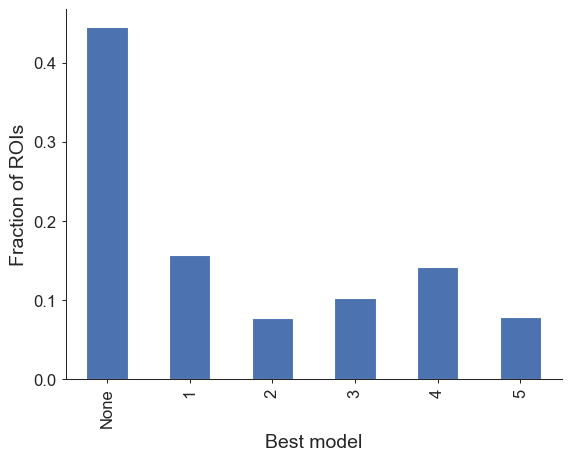

In [229]:
sig_fit_df.best_model.value_counts(normalize=True).reindex(["None"] + list(range(1, len(models)+1))).plot(kind="bar")
plt.xlabel("Best model")
plt.ylabel("Fraction of ROIs")

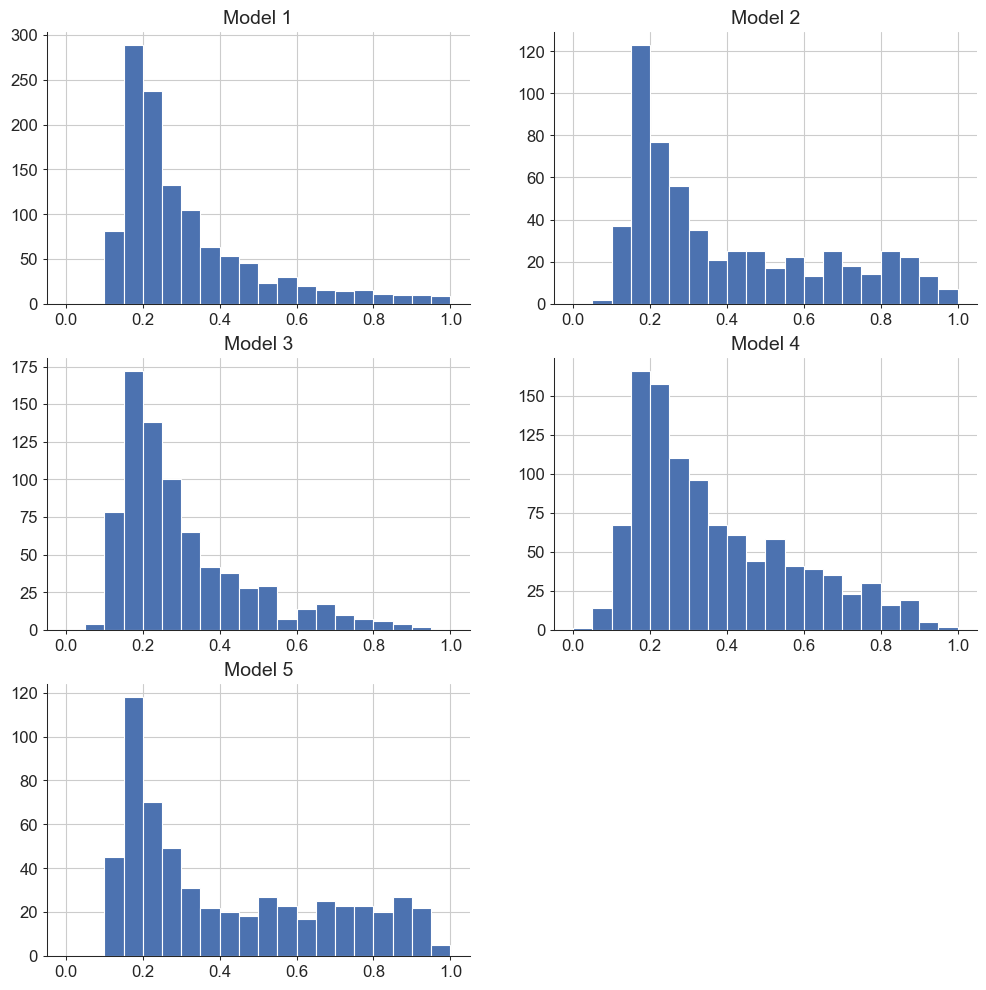

In [230]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=3, ncols=2)

for i, ax in enumerate(axs.flat):
    if i < len(MODELS):
        models_df[f"r_valid_model{i+1}"][sig_fit_df.best_model == i+1].hist(bins=np.arange(0, 1.05, 0.05), ax=ax)
        ax.set_title(f"Model {i+1}")
    else:
        ax.axis("off")

# Look at quantiles for null metrics

In [231]:
pct_dist = []
for roi_id, model_id in sig_fit_df[sig_fit_df.best_model != "None"].best_model.items():
    null_metrics = models_df.at[roi_id, f"r_valid_null_model{model_id}"]
    if not pd.isna(null_metrics):
        null_metrics = eval(null_metrics)
        obs_metric = models_df.at[roi_id, f"r_test_model{model_id}"]
        # pctile = spstats.percentileofscore(null_metrics, obs_metric)
        pctile = (obs_metric >= np.array(null_metrics)).mean()
        pct_dist.append(pctile)
pct_dist = np.array(pct_dist)
for p in np.unique(pct_dist):
    print(f"≥{p}: {np.sum(pct_dist >= p)} ROIs")

≥0.95: 4140 ROIs
≥0.96: 3947 ROIs
≥0.97: 3710 ROIs
≥0.98: 3428 ROIs
≥0.99: 3070 ROIs
≥1.0: 2555 ROIs


In [232]:
df = pd.merge(sig_fit_df[["responsive_models", "best_model"]], metrics_df[["frac_resp_trials_w", "frac_resp_trials_f"]], how="left", left_index=True, right_index=True)
df

responsive_models best_model  frac_resp_trials_w  \
roi_id                                                              
M409828_11_0_89                  1          1            0.375000   
M409828_11_1_159        1, 2, 3, 5          3            0.500000   
M409828_11_1_2                None       None            0.500000   
M409828_11_1_4                   1          1            0.428571   
M409828_11_2_0       1, 2, 3, 4, 5          4            0.714286   
...                            ...        ...                 ...   
M409828_1f_0_70         1, 2, 3, 5          5            0.142857   
M409828_1f_0_74            1, 3, 4          4            0.250000   
M409828_1f_0_8                   4          4            0.285714   
M409828_1f_0_9                None       None            0.375000   
M409828_1f_0_90                  1          1            0.125000   

                  frac_resp_trials_f  
roi_id                                
M409828_11_0_89                0.500  
M409828_11_1_159               0.250  
M409828_11_1_2                 0.625  
M409828_11_1_4                 0.125  
M409828_11_2_0                 0.875  
...                              ...  
M409828_1f_0_70                0.625  
M409828_1f_0_74                0.375  
M409828_1f_0_8                 0.000  
M409828_1f_0_9                 0.500  
M409828_1f_0_90                0.400  

[7464 rows x 4 columns]

Text(0, 0.5, 'fraction')

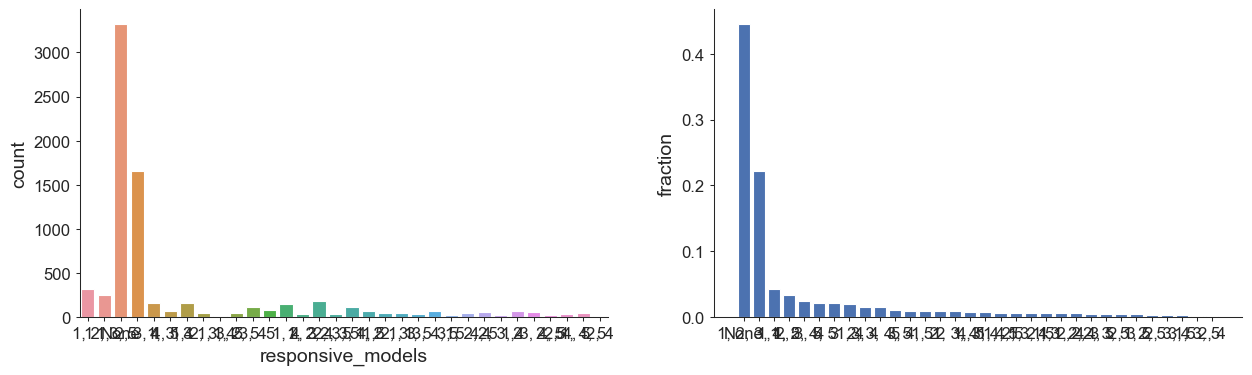

In [233]:
fig, axs = plt.subplots(figsize=(15, 4), ncols=2)
sns.countplot(data=df, x="responsive_models", ax=axs[0])
c = sig_fit_df.responsive_models.value_counts(normalize=True)
axs[1].bar(c.index, c.values)
axs[1].set_ylabel("fraction")

<Axes: xlabel='responsive_models', ylabel='frac_resp_trials_f'>

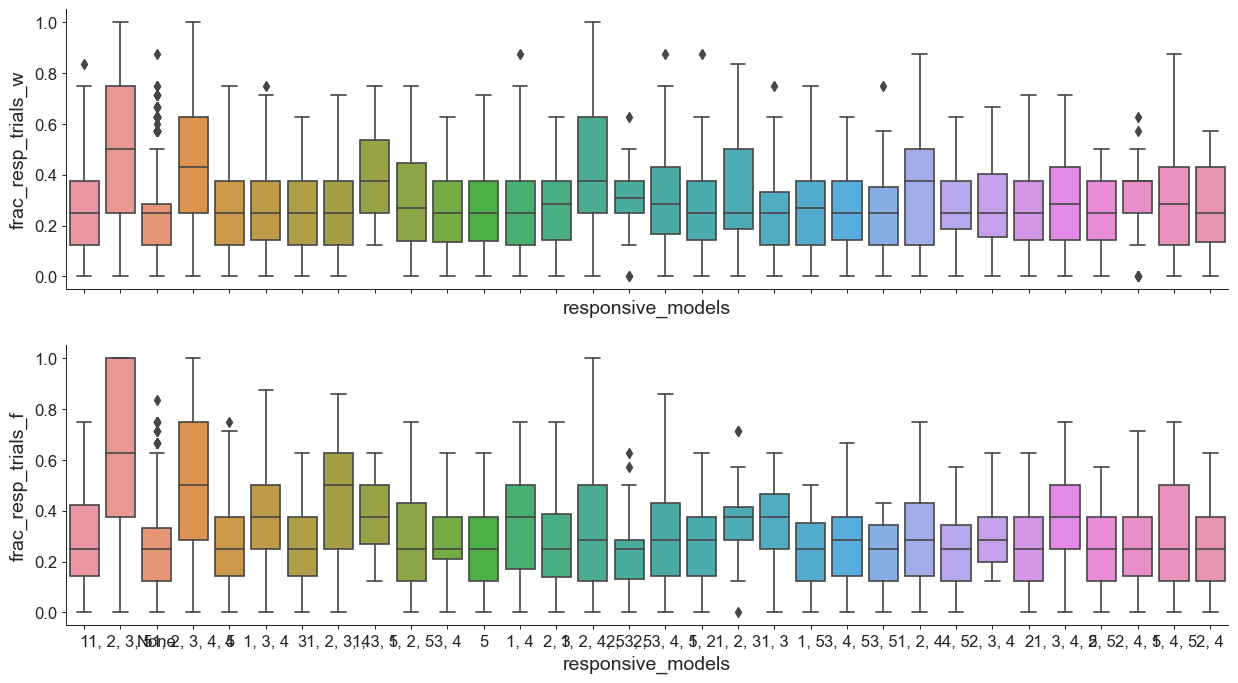

In [234]:
fig, axs = plt.subplots(figsize=(15, 8), nrows=2, sharex=True)
sns.boxplot(data=df, x="responsive_models", y="frac_resp_trials_w", ax=axs[0])
sns.boxplot(data=df, x="responsive_models", y="frac_resp_trials_f", ax=axs[1])

# Example responses for best models

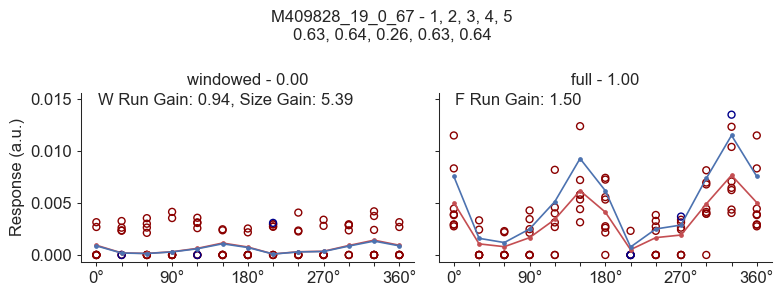

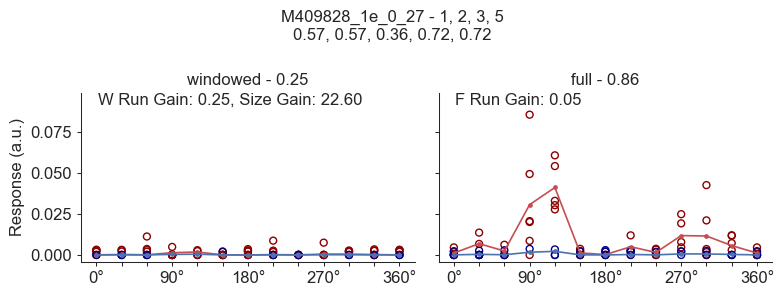

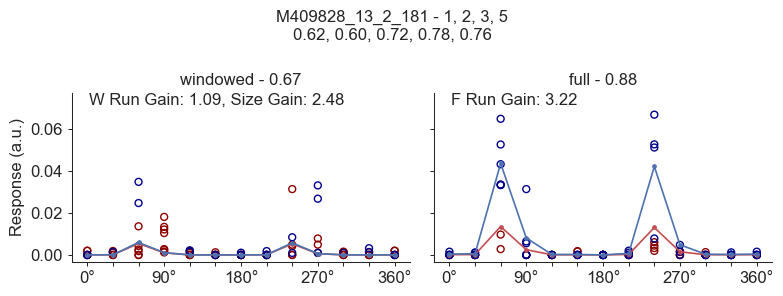

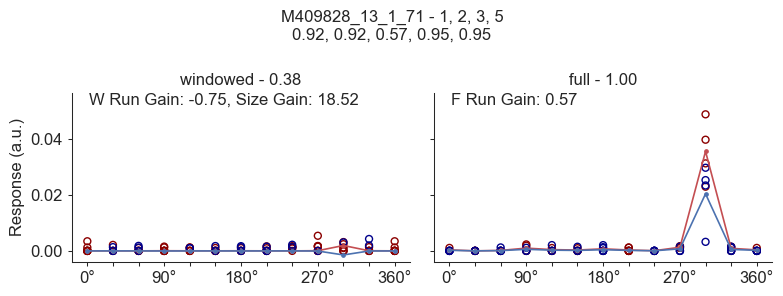

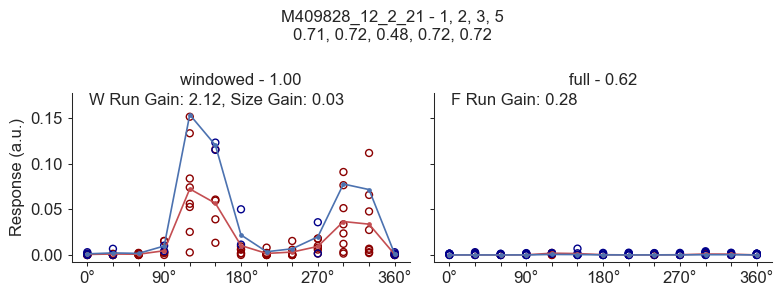

In [237]:
n = 5
# model_key = "None"
model_key = 5
random_roi_ids = np.random.choice(df.index[(df.best_model == model_key) & (models_df[f"r_valid_model{model_key}"] >= 0.5)], size=n, replace=False)

for roi_id in random_roi_ids:
    r1, r2, r3, r4, r5 =  models_df.loc[roi_id, ["r_valid_model1", "r_valid_model2", "r_valid_model3", "r_valid_model4", "r_valid_model5"]].values
    fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {df.at[roi_id, 'responsive_models']}\n{r1:.2f}, {r2:.2f}, {r3:.2f}, {r4:.2f}, {r5:.2f}", figscale=(4, 3))
    plotting.plot_trial_responses(roi_id, axs)
    wrt = metrics_df.at[roi_id, "frac_resp_trials_w"]
    frt = metrics_df.at[roi_id, "frac_resp_trials_f"]
    for ax, rt in zip(axs, (wrt, frt)):
        ax.set_title(f"{ax.get_title()} - {rt:.2f}", fontsize=12)
    
    if model_key != "None":
        # print(models_df.at[roi_id, f"state_model{model_key}"])
        plotting.plot_model_fit(MODELS, models_df, model_key=model_key, roi_id=roi_id, axs=axs)

In [174]:
from allen_v1dd.stimulus_analysis.dg_models import DGModelDirectionTuningSizeDualRunningGain

M409828_12_3:   0%|          | 0/1 [00:00<?, ?it/s]

roi_id  r_valid    r_test  r2_valid   r2_test  mse_valid  \
0  M409828_12_3_31  0.93235  0.934576  0.788157  0.801392   0.000021   

   mse_test                                              state   r_train  \
0   0.00002  [1.7977632525503326e-06, 5.797405085561669e-05...  0.927136   

   r2_train  mse_train  
0  0.858434   0.000014

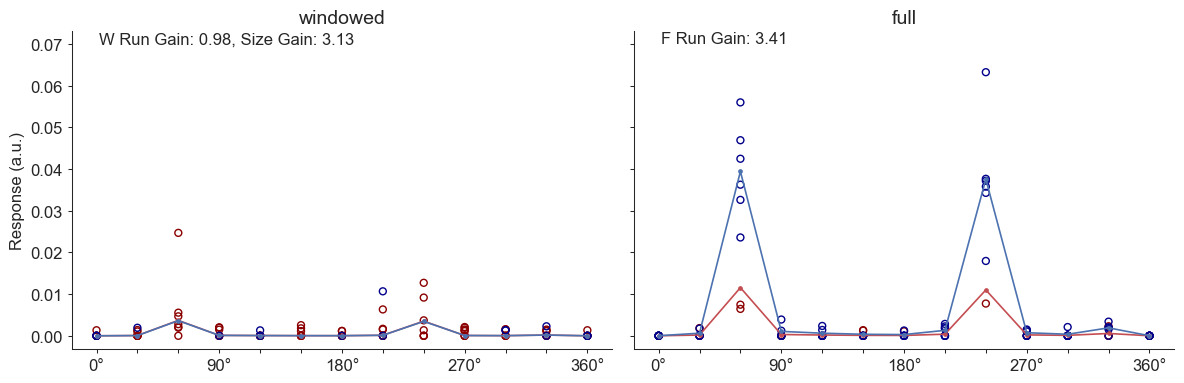

In [187]:
roi_id = "M409828_12_3_31"
filt = at.plane_group_filter(roi_id, roi_in_filter=True)
# test_model = DGModelDirectionTuningSizeRunningGain()
test_model = DGModelDirectionTuningSizeDualRunningGain()

d = training.train_and_evaluate(test_model, plane_group_filter=filt, kfold_splitter_fn=get_kfold_splitter(), build_null_dist=False)

fig, axs = plotting.build_figure()
plotting.plot_trial_responses(roi_id, axs=axs)
test_model.plot_fit(axs)

d

# Model 1
Linear regression where features represent DG direction
$$L(w) = \frac{1}{T} \sum_{t=0}^{T-1} \left( r_t - \underbrace{\sum_{d=0}^{F-1} X_{t,d} w_d}_\text{Predicted} \right)^2$$
Since this is a linear system we can solve it easily using matrix inverses. Let $R \in \mathbb{R}^{T \times N}$ be the trial responses for $N$ neurons, and $W \in \mathbb{R}^{D \times N}$ be the corresponding linear regression weight matrix. We aim to fit $R \approx XW$, so the least squares solution is $W = (X^TX)^{-1}X^TR$.

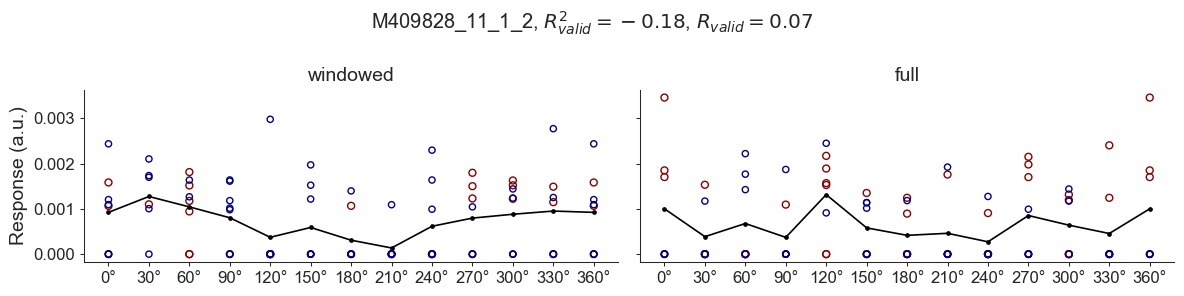

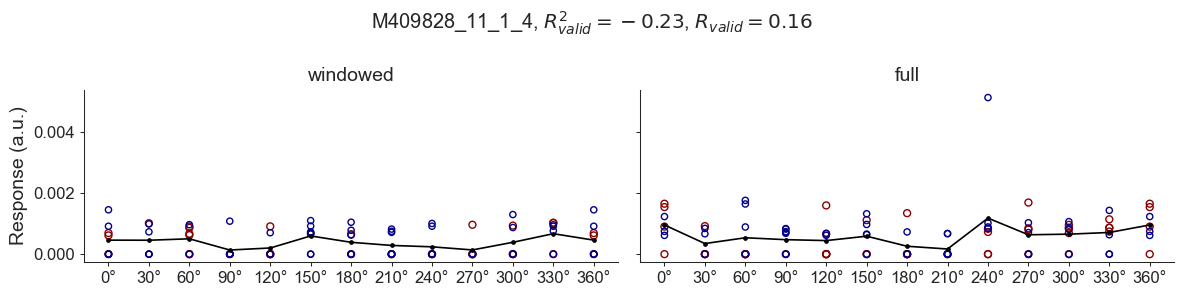

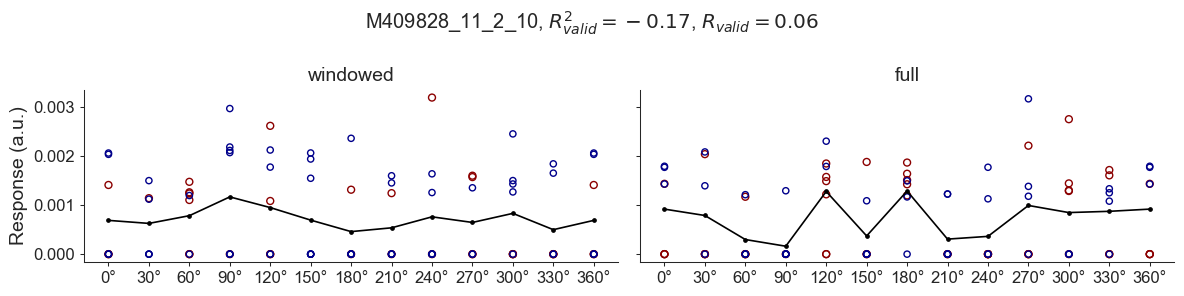

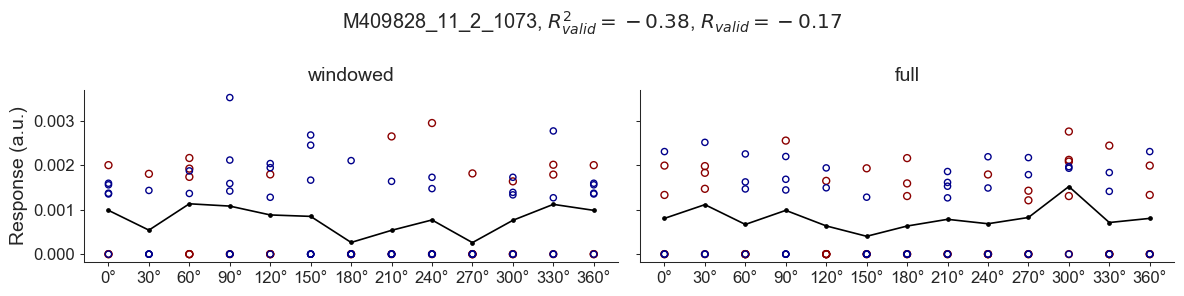

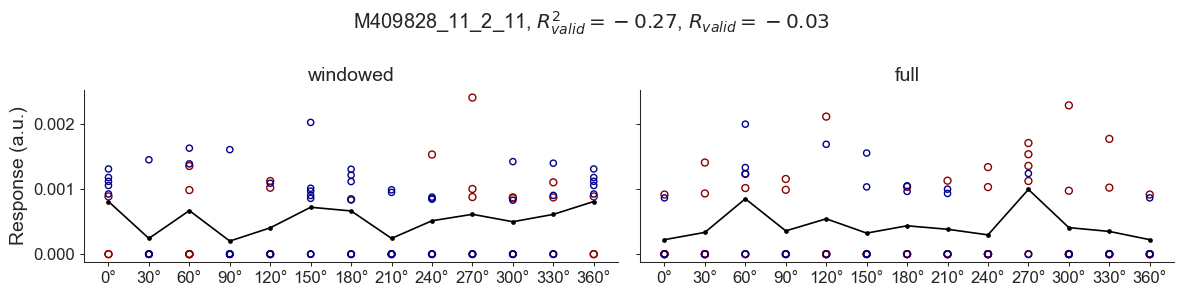

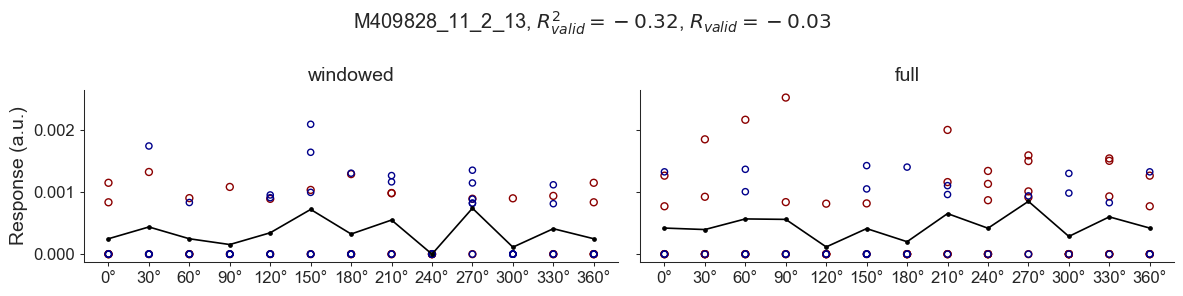

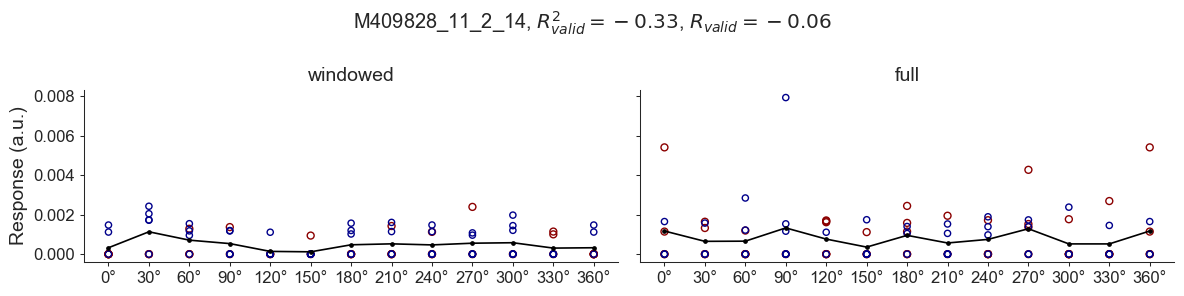

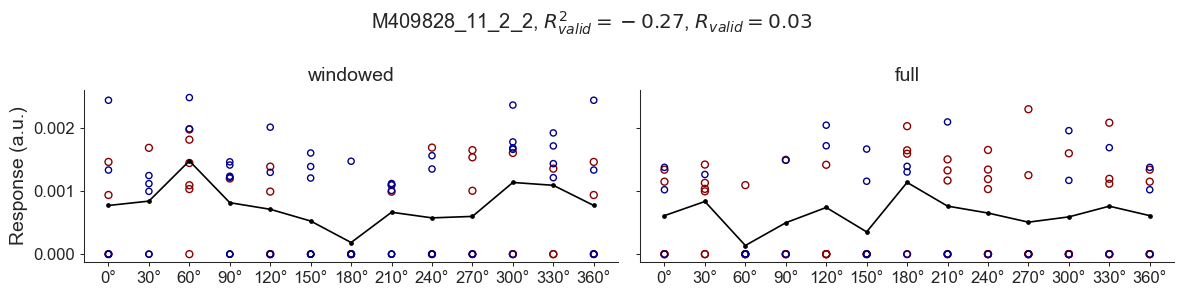

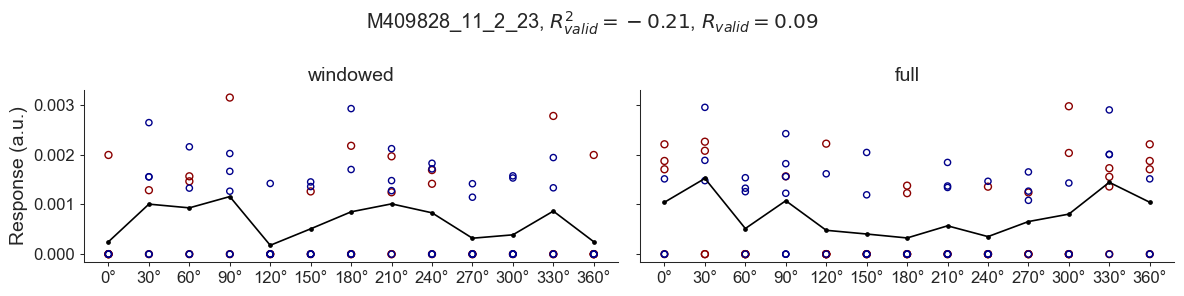

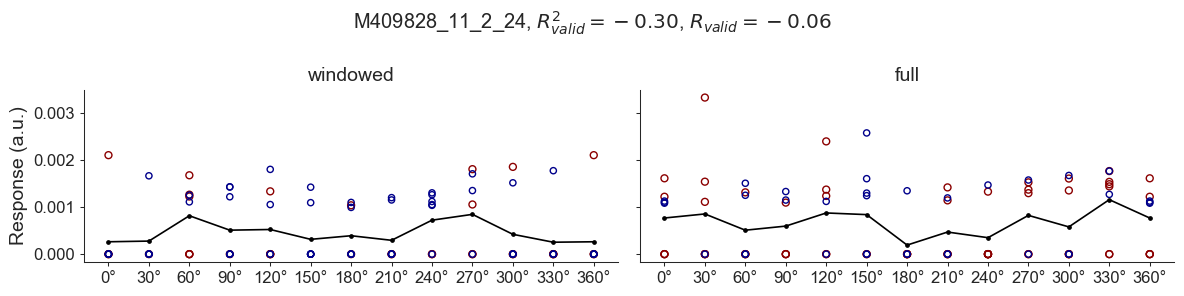

In [948]:
# Plot out results for good fits
for roi_id in is_good_fit.index[is_good_fit == False][:10]:
    fig, axs = debug_plot_responses(roi_id)
    fig.suptitle(f"{roi_id}, $R^2_{{valid}} = {mdf.at[roi_id, 'r2_valid']:.2f}$, $R_{{valid}} = {mdf.at[roi_id, 'r_valid']:.2f}$")
    tc = mdf.at[roi_id, "tuning_curve"]
    axs[0].plot(directions, np.take(tc[:12], indices=range(len(directions)), mode="wrap"), color="black", marker=".")
    axs[1].plot(directions, np.take(tc[12:], indices=range(len(directions)), mode="wrap"), color="black", marker=".")

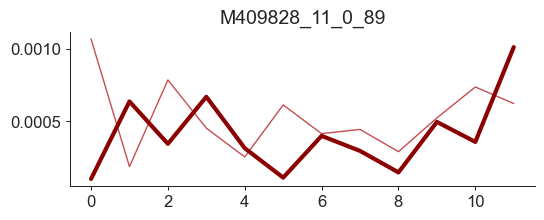

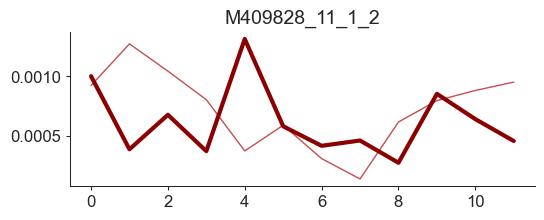

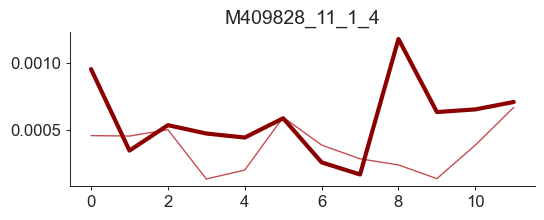

In [148]:
# Plot out some sample tuning curves
for i in range(3):
    plt.figure(figsize=(6, 2))
    tc = model_1_df.tuning_curve.values[i]
    plt.plot(tc[:12], color="r", linewidth=1)
    plt.plot(tc[12:], color="darkred", linewidth=3)
    plt.title(model_1_df.roi_id.values[i])

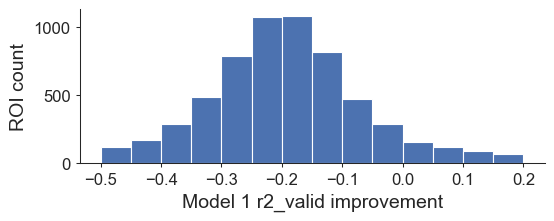

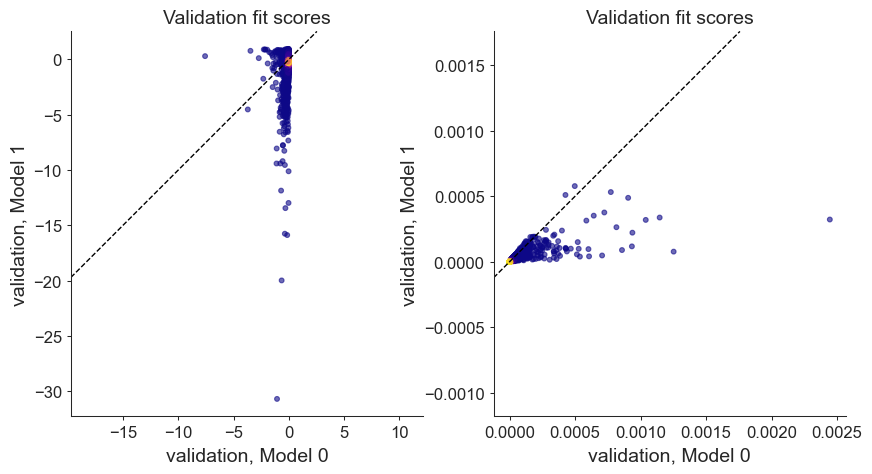

In [567]:
fig, ax = plt.subplots(figsize=(6, 2))
metric = "r2_valid"
ax.hist(model_1_df[metric] - model_0_df[metric], bins=np.arange(-0.5, 0.25, 0.05))
ax.set_xlabel(f"Model 1 {metric} improvement")
ax.set_ylabel("ROI count")

fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

for ax, metric, label in zip(axs, ("r2_valid", "mse_valid"), ("validation", "validation")):
    at.density_scatter(model_0_df[metric], model_1_df[metric], ax=ax)
    ax.set_xlabel(f"{label}, Model 0")
    ax.set_ylabel(f"{label}, Model 1")
    ax.axis("equal")
    ax.axline((0, 0), slope=1, color="black", linestyle="dashed", linewidth=1)
    ax.set_title(f"{label.capitalize()} fit scores")

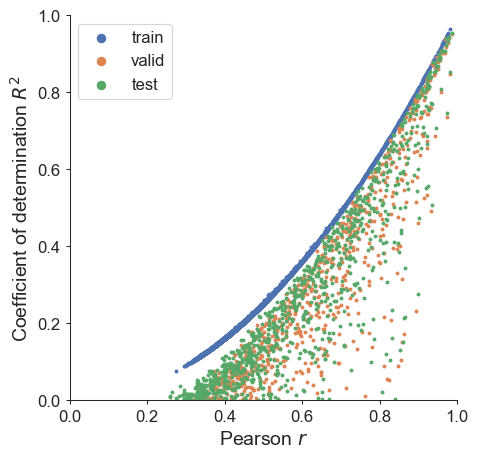

In [505]:
plt.figure(figsize=(5, 5))
plt.scatter(model_uncombined_df.r_train, model_uncombined_df.r2_train, s=4, label="train")
plt.scatter(model_uncombined_df.r_valid, model_uncombined_df.r2_valid, s=4, label="valid")
plt.scatter(model_uncombined_df.r_test, model_uncombined_df.r2_test, s=4, label="test")
plt.xlabel("Pearson $r$")
plt.ylabel("Coefficient of determination $R^2$")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc="upper left", markerscale=3)

Compare Model 0 to Model 1

In [272]:
model_combined_df

mouse  column volume  plane  depth            roi_id   r_train  \
0     409828       1      1      0     50   M409828_11_0_89  0.291040   
1     409828       1      1      1     66    M409828_11_1_2  0.274702   
2     409828       1      1      1     66    M409828_11_1_4  0.296248   
3     409828       1      1      1     66  M409828_11_1_159  0.375459   
4     409828       1      1      2     82    M409828_11_2_0  0.600754   
...      ...     ...    ...    ...    ...               ...       ...   
7459  409828       1      f      0    725   M409828_1f_0_67  0.333970   
7460  409828       1      f      0    725   M409828_1f_0_69  0.254923   
7461  409828       1      f      0    725   M409828_1f_0_70  0.285397   
7462  409828       1      f      0    725   M409828_1f_0_74  0.341964   
7463  409828       1      f      0    725   M409828_1f_0_90  0.282635   

       r_valid    r_test  r2_train  r2_valid   r2_test     mse_train  \
0     0.022905  0.031068  0.085706 -0.124412 -0.095215  3.193456e-07   
1     0.024756  0.028165  0.075720 -0.136798 -0.109153  6.252542e-07   
2     0.060222  0.082129  0.089305 -0.105492 -0.071233  3.262230e-07   
3     0.208514  0.222275  0.141986 -0.099056 -0.074290  7.487225e-07   
4     0.524582  0.536954  0.361573  0.205685  0.225159  2.110639e-04   
...        ...       ...       ...       ...       ...           ...   
7459  0.138667  0.151566  0.112330 -0.064940 -0.040825  3.216292e-06   
7460 -0.027094 -0.006357  0.067089 -0.140447 -0.111228  1.168579e-05   
7461  0.022200  0.025238  0.082141 -0.335984 -0.227934  7.644799e-05   
7462  0.158159  0.173995  0.117780 -0.086672 -0.059610  2.304180e-06   
7463  0.042689  0.043479  0.081251 -0.106800 -0.079602  3.749989e-06   

         mse_valid      mse_test  frac_resp_trials_w  frac_resp_trials_f  \
0     3.870079e-07  3.774131e-07            0.375000               0.500   
1     7.459299e-07  7.280654e-07            0.500000               0.625   
2     3.913149e-07  3.816848e-07            0.428571               0.125   
3     8.938873e-07  8.735411e-07            0.500000               0.250   
4     2.502152e-04  2.444515e-04            0.714286               0.875   
...            ...           ...                 ...                 ...   
7459  3.774521e-06  3.695313e-06            0.125000               0.200   
7460  1.404367e-05  1.370509e-05            0.285714               0.250   
7461  9.436776e-05  9.170298e-05            0.142857               0.625   
7462  2.722402e-06  2.660614e-06            0.250000               0.375   
7463  4.448199e-06  4.345274e-06            0.125000               0.400   

      pref_sf_idx_w  pref_sf_idx_f  \
0                 0              1   
1                 0              0   
2                 0              0   
3                 0              0   
4                 1              1   
...             ...            ...   
7459              1              0   
7460              1              0   
7461              0              1   
7462              0              1   
7463              0              0   

                                           tuning_curve  
0     [0.0005856232346559412, 0.00043068780527951643...  
1     [0.0009595085013036925, 0.000795598213489239, ...  
2     [0.0006883306312374771, 0.00039574707177682564...  
3     [0.0007599811302497982, 0.0007215277202284107,...  
4     [0.023779719173035133, 0.030495217959729162, 0...  
...                                                 ...  
7459  [0.0010138548968825494, 0.0007967562560224906,...  
7460  [0.00143652800761629, 0.0007455668383045122, 0...  
7461  [0.005124727496877313, 0.0020661664505799604, ...  
7462  [0.0008673203100139897, 0.0008999966395397979,...  
7463  [0.0010835764929652213, 0.001849507478376229, ...  

[7464 rows x 20 columns]

(array([  55.,  136.,  392.,  725., 1034., 1125.,  963.,  745.,  499.,
         328.,  237.,  188.,  179.,  144.,  118.,  100.,  100.,   88.,
          80.,   52.,   66.,   48.,   40.,   17.]),
 array([-2.00000000e-01, -1.50000000e-01, -1.00000000e-01, -5.00000000e-02,
        -5.55111512e-17,  5.00000000e-02,  1.00000000e-01,  1.50000000e-01,
         2.00000000e-01,  2.50000000e-01,  3.00000000e-01,  3.50000000e-01,
         4.00000000e-01,  4.50000000e-01,  5.00000000e-01,  5.50000000e-01,
         6.00000000e-01,  6.50000000e-01,  7.00000000e-01,  7.50000000e-01,
         8.00000000e-01,  8.50000000e-01,  9.00000000e-01,  9.50000000e-01,
         1.00000000e+00]),
 <BarContainer object of 24 artists>)

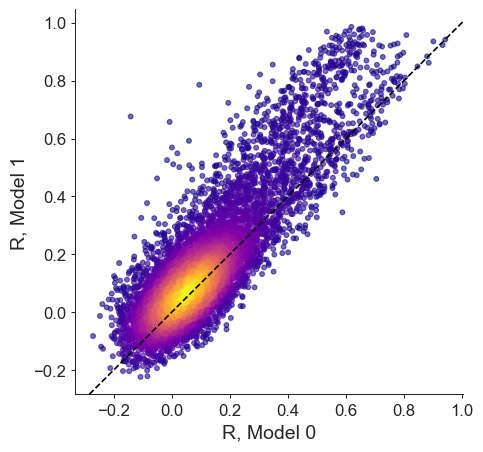

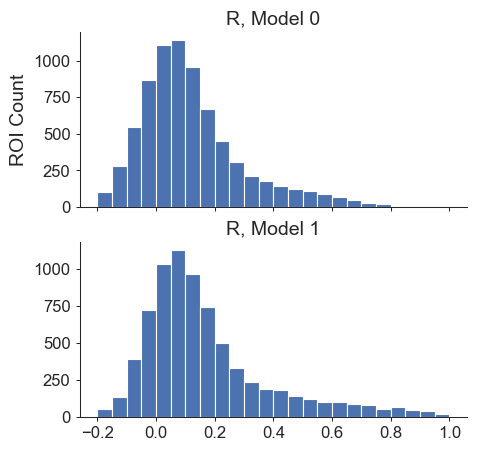

In [284]:
df = pd.merge(model_combined_df, model_uncombined_df, how="inner", on="roi_id", suffixes=["_model0", "_model1"])
fig, ax = plt.subplots(figsize=(5, 5))
at.density_scatter(df.r_valid_model0, df.r_valid_model1, ax=ax)
ax.axis("equal")
ax.axline((0, 0), slope=1, color="black", linestyle="dashed")
ax.set_xlabel("R, Model 0")
ax.set_ylabel("R, Model 1")

fig, axs = plt.subplots(figsize=(5, 5), nrows=2, sharex=True)
bins = np.arange(-0.2, 1.05, 0.05)
axs[0].set_title("R, Model 0")
axs[0].hist(model_combined_df.r_valid, bins=bins)
axs[0].set_ylabel("ROI Count")
axs[1].set_title("R, Model 1")
axs[1].hist(model_uncombined_df.r_valid, bins=bins)

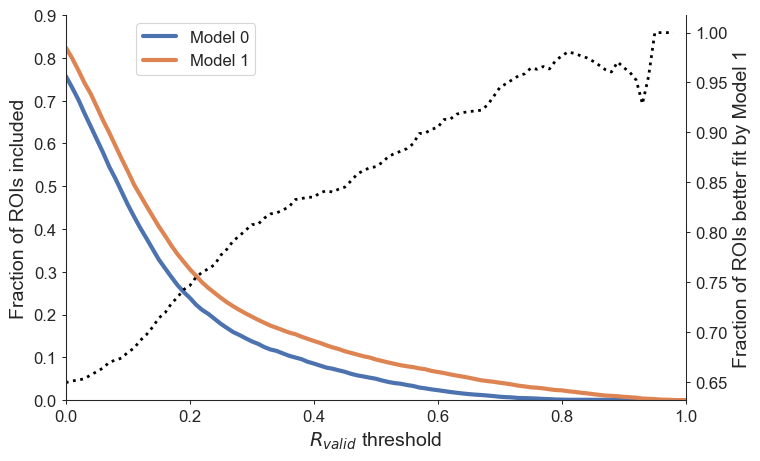

In [311]:
# How does fit compare between models?
fig, ax_frac_incl = plt.subplots(figsize=(8, 5))

r_thresh = np.arange(0, 1.01, 0.01)
ax_frac_incl.plot(r_thresh, [(model_combined_df.r_valid > r).mean() for r in r_thresh], linewidth=3, label="Model 0")
ax_frac_incl.plot(r_thresh, [(model_uncombined_df.r_valid > r).mean() for r in r_thresh], linewidth=3, label="Model 1")
ax_frac_incl.set_xlabel("$R_{valid}$ threshold")
ax_frac_incl.set_ylabel("Fraction of ROIs included")
ax_frac_incl.set_xlim(r_thresh.min(), r_thresh.max())
ax_frac_incl.set_ylim(0, 0.9)

ax_frac_incl.legend(loc="upper left")
ax_frac_incl.legend(loc="upper left", bbox_to_anchor=(0.1, 1), bbox_transform=ax_frac_incl.transAxes)

ax_model_1_better = ax_frac_incl.twinx()
is_model_1_better = df.r_valid_model1 > df.r_valid_model0
ax_model_1_better.plot(r_thresh, [is_model_1_better[(df.r_valid_model0 >= r) | (df.r_valid_model1 >= r)].mean() for r in r_thresh], color="black", linewidth=2, linestyle="dotted")
ax_model_1_better.set_ylabel("Fraction of ROIs better fit by Model 1")
ax_model_1_better.spines["right"].set_visible(True)


28.56391372961599
69.9815837937385 % ROIs are better fit by Model 1


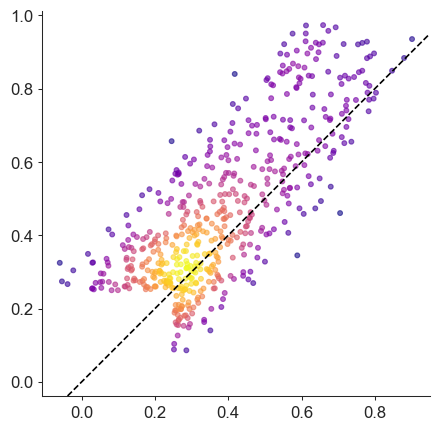

In [138]:
cols = ["roi_id", "r_valid", "r2_valid", "r_test", "r2_test"]
df = pd.merge(model_combined_df[cols], model_uncombined_df[cols], how="inner", on="roi_id", suffixes=["_model0", "_model1"])

incl = (df.r_valid_model0 >= 0.25) | (df.r_valid_model1 >= 0.25)

print(incl.mean()*100)

fig, ax = plt.subplots(figsize=(5, 5))

x, y = df.r_valid_model0[incl], df.r_valid_model1[incl]
at.density_scatter(x, y, ax=ax)
print((y > x).mean() * 100, "% ROIs are better fit by Model 1")
ax.axis("equal")
ax.axline((0, 0), slope=1, color="black", linestyle="dashed")

Look at normalized tuning curves across the population

Text(0.5, 0, 'Direction relative to preferred')

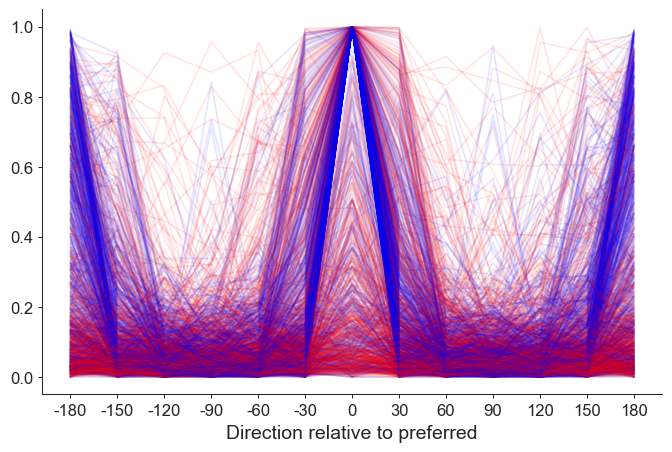

In [170]:
all_tcs = np.vstack(model_uncombined_df.tuning_curve[model_uncombined_df.r_valid >= 0.5].values)
norm_tcs = all_tcs / np.max(all_tcs, axis=1, keepdims=True)
tc_idx = np.arange(13) % 12 # wrap around to 0 (i.e., 360) at the end
# norm_tc_w, norm_tc_f = norm_tcs[:, tc_idx], norm_tcs[:, 12+tc_idx]
norm_tc_w, norm_tc_f = norm_tcs[:, :12], norm_tcs[:, 12:]

# TODO: np.roll(arr, x) moves the array right by x spots

fig, ax = plt.subplots(figsize=(8, 5))

for i, j_peak in enumerate(norm_tcs.argmax(axis=1) % 12):
    tc_w = norm_tc_w[i, (tc_idx + j_peak + 6) % 12]
    tc_f = norm_tc_f[i, (tc_idx + j_peak + 6) % 12]
    ax.plot(tc_w, color="red", alpha=0.1)
    ax.plot(tc_f, color="blue", alpha=0.1)

ax.set_xticks(ticks=np.arange(13), labels=np.arange(-180, 210, 30))
ax.set_xlabel("Direction relative to preferred")

Text(0, 0.5, '$R^2$ (Model 1)')

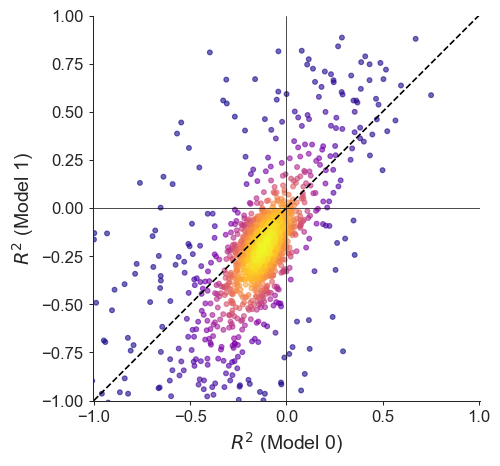

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
at.density_scatter(model_combined_df.r2_test, model_uncombined_df.r2_test, ax=ax)
ax.axis("equal")
ax.axline((0, 0), slope=1, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.axhline(y=0, color="black", linewidth=0.5)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("$R^2$ (Model 0)")
ax.set_ylabel("$R^2$ (Model 1)")

# Model 2
Fit a single tuning curve across DG conditions and use a multiplicative gain term to model the gain for different DG sizes. The trials are encoded into feature vectors $x_i \in \mathbb{R}^{12}$ as follows:
$$x_i = \begin{bmatrix} \underbrace{0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0}_\text{One-hot direction encoding}, \underbrace{0}_\text{Binary size encoding (0 = DGW, 1 = DGF)} \end{bmatrix}$$
Let $w \in \mathbb{R}^{14}$ denote model weights and define the superscript $^{(D)}$ on $w$ or $x_i$ to denote the first 12 elements (encoding direction) and $^{(S)}$ to denote the last element (encoding size). The prediction for trial $i$ is then
$$\begin{align*}
    \hat{y}_i &= (x_i^{(D)} \cdot w^{(D)}) \times \begin{cases}
        1 & \text{if } x_i^{(S)} = 0 \\
        w^{(S)} & \text{otherwise}
    \end{cases} \\
    &= (x_i^{(D)} \cdot w^{(D)}) (x_i^{(S)}w^{(S)} + (1 - x_i^{(S)}))
\end{align*}$$
which effectively scales the direction tuning curve for different sized DG stimuli. The optimal weights $w$ are solved by minimizing the sum of squares between predicted ($\hat{y}_i$) and true ($y_i$) responses:
$$L(w) = \sum_{i} (y_i - \hat{y}_i)^2$$

First make sure the gradients we're computing are correct!

In [639]:
n, d = 50, 14
X = np.random.randn(n, d)
y_true = np.random.randn(n)
weights = np.random.randn(d)

In [634]:
def f(w):
    y_pred = X[:, :12].dot(w[:12]) * (X[:, -2]*w[-2] + (1-X[:, -2])) * (X[:, -1]*w[-1] + (1-X[:, -1]))
    return np.sum(np.square(y_true - y_pred))

In [637]:
def f_grad(w):
    wD, wS, wL = w[:12], w[-2], w[-1]
    XD, XS, XL = X[:, :12], X[:, -2], X[:, -1]
    dir_pred = XD.dot(wD)
    size_gain = (XS*wS + (1-XS))
    run_gain = (XL*wL + (1-XL))

    y_pred = dir_pred * size_gain * run_gain
    d_ypred_wrt_w = np.empty((d, n))
    d_ypred_wrt_w[:12] = XD.T * size_gain * run_gain
    d_ypred_wrt_w[-2] = dir_pred * run_gain * XS
    d_ypred_wrt_w[-1] = dir_pred * size_gain * XL
    grad = -2 * d_ypred_wrt_w.dot(y_true-y_pred)
    return grad

# def f_grad_slow(w):
#     y_pred = X[:, :12].dot(w[:12]) * (X[:, -1]*w[-1] + (1-X[:, -1]))
#     residual = y_true - y_pred
#     grad = np.zeros_like(w)
#     for i in range(n):
#         grad[:12] += residual[i] * ((X[i, -1] * w[-1] + (1 - X[i, -1])) * X[i, :12])
#         grad[-1] += residual[i] * (X[i, :12].dot(w[:12])*X[i, -1])
#     grad *= -2
#     return grad

def f_grad_numdiff(w, h=1e-5):
    delta = np.empty(d)
    grad = np.empty(d)

    for i in range(d):
        delta[:] = 0
        delta[i] = h
        grad[i] = (f(w+delta) - f(w-delta)) / (2*h)

    return grad

In [640]:
# Gold standard
f_grad_numdiff(weights)

array([ -112.97611209,  -293.51506114,   -75.66016143,  1271.39958281,
        1346.43979627,  -797.05280432, -1876.46205891, -2302.43330652,
        1990.14013679,  1264.55501254,   351.26684493,   567.87722233,
       -7778.96689078, -3762.07457653])

In [20]:
# f_grad_slow(weights)

array([  183.24733269,   189.29608871,   320.63219264,   -91.49784158,
         245.93132242,  -135.30322269,  1163.14737247,  -266.3546112 ,
       -1158.02062566, -1434.42723909,  -456.37445488,   116.77069355,
       -2964.86907806])

In [641]:
f_grad(weights)

array([ -112.97611212,  -293.51506104,   -75.66016134,  1271.39958277,
        1346.43979626,  -797.05280432, -1876.46205895, -2302.43330649,
        1990.14013669,  1264.55501256,   351.26684501,   567.8772224 ,
       -7778.96689087, -3762.07457646])

In [21]:
model_2 = DGModelSimpleTuningSizeGain()
model_2_save_file = path.join(MODEL_SAVE_DIRECTORY, "model_2.csv")
# model_2_df = train_and_evaluate(model_2, plane_group_filter=plane_group_filter, kfold_splitter_fn=kfold_splitter_fn, save_file=model_2_save_file, suppress_warnings=True)
model_2_df = pd.read_csv(model_2_save_file)

model_2_df

roi_id   r_valid    r_test  r2_valid   r2_test     mse_valid  \
0      M409828_11_0_89  0.065410  0.080779 -0.169285 -0.140914  3.838127e-07   
1       M409828_11_1_2  0.112385  0.126412 -0.049733 -0.032385  7.038499e-07   
2       M409828_11_1_4  0.074030  0.079385 -0.149064 -0.118879  3.858043e-07   
3     M409828_11_1_159  0.221961  0.236782 -0.004802  0.019537  8.725889e-07   
4       M409828_11_2_0  0.653129  0.668828  0.287557  0.320349  2.055601e-04   
...                ...       ...       ...       ...       ...           ...   
7459   M409828_1f_0_67  0.161598  0.192626 -0.078609 -0.042620  3.792690e-06   
7460   M409828_1f_0_69  0.030391  0.047965 -0.127886 -0.104688  1.412570e-05   
7461   M409828_1f_0_70  0.282013  0.300154 -0.404686 -0.297049  8.875345e-05   
7462   M409828_1f_0_74  0.070488  0.101089 -0.145564 -0.108132  2.920508e-06   
7463   M409828_1f_0_90  0.076350  0.087908 -0.072045 -0.051982  4.357472e-06   

          mse_test  expl_var_valid  expl_var_test   r_train  r2_train  \
0     3.744732e-07       -0.077271      -0.054380  0.275987  0.076033   
1     6.926422e-07       -0.025950      -0.010252  0.254462  0.064741   
2     3.780799e-07       -0.108712      -0.081706  0.241923  0.057789   
3     8.524801e-07        0.002027       0.025631  0.389186  0.150724   
4     1.951083e-04        0.310463       0.342311  0.750927  0.563822   
...            ...             ...            ...       ...       ...   
7459  3.695080e-06       -0.035485      -0.003680  0.294183  0.086031   
7460  1.391946e-05       -0.121330      -0.098463  0.293300  0.085191   
7461  8.525875e-05       -0.358616      -0.253917  0.463524  0.214626   
7462  2.838479e-06       -0.133329      -0.097034  0.305556  0.093103   
7463  4.276842e-06       -0.057512      -0.038524  0.308195  0.094307   

         mse_train  expl_var_train  \
0     3.228932e-07        0.076047   
1     6.335832e-07        0.064742   
2     3.373306e-07        0.057865   
3     7.437323e-07        0.150817   
4     1.444169e-04        0.563873   
...            ...             ...   
7459  3.315704e-06        0.086120   
7460  1.146530e-05        0.085389   
7461  6.524326e-05        0.214750   
7462  2.372265e-06        0.093160   
7463  3.699156e-06        0.094414   

                                                weights  \
0     [0.0006288971815095078, 0.0004393697970746906,...   
1     [0.0009938083295549026, 0.0008500684036951452,...   
2     [0.0007033864527938907, 0.0004155682753983856,...   
3     [0.000797682026359493, 0.0007649540326317383, ...   
4     [0.009316627199658999, 0.00858098933420249, 0....   
...                                                 ...   
7459  [0.0010452513823039711, 0.0008208409773600217,...   
7460  [0.0019120335229742876, 0.0006882194841866708,...   
7461  [0.0010661100235930645, 0.0004657962144205784,...   
7462  [0.0009178564448793562, 0.0009295854082890138,...   
7463  [0.0007469527783240612, 0.0015250138896831208,...   

                                          tuning_curves  
0     [0.0006288971815095078, 0.0004393697970746906,...  
1     [0.0009938083295549026, 0.0008500684036951452,...  
2     [0.0007033864527938907, 0.0004155682753983856,...  
3     [0.000797682026359493, 0.0007649540326317383, ...  
4     [0.009316627199658999, 0.00858098933420249, 0....  
...                                                 ...  
7459  [0.0010452513823039711, 0.0008208409773600217,...  
7460  [0.0019120335229742876, 0.0006882194841866708,...  
7461  [0.0010661100235930645, 0.0004657962144205784,...  
7462  [0.0009178564448793562, 0.0009295854082890138,...  
7463  [0.0007469527783240612, 0.0015250138896831208,...  

[7464 rows x 15 columns]

In [22]:
model_2_null_df_save_file = path.join(MODEL_SAVE_DIRECTORY, "model_2_null.csv")
# model_2_null_df = build_fit_null_distribution(model_2, plane_group_filter=plane_group_filter, n_shuffles=100, suppress_warnings=True, save_file=model_2_null_df_save_file)
model_2_null_df = pd.read_csv(model_2_null_df_save_file)
model_2_null_df

roi_id  shuffle         r        r2           mse  expl_var
0       M409828_11_0_89        0  0.335939  0.112757  3.100597e-07  0.112772
1       M409828_11_0_89        1  0.302120  0.091144  3.176125e-07  0.091160
2       M409828_11_0_89        2  0.257924  0.066285  3.263000e-07  0.066310
3       M409828_11_0_89        3  0.228623  0.052254  3.312034e-07  0.052255
4       M409828_11_0_89        4  0.207290  0.042488  3.346160e-07  0.042525
...                 ...      ...       ...       ...           ...       ...
746395  M409828_1f_0_90       95  0.169535  0.028531  3.967809e-06  0.028542
746396  M409828_1f_0_90       96  0.260485  0.067852  3.807207e-06  0.067852
746397  M409828_1f_0_90       97  0.308005  0.094808  3.697108e-06  0.094816
746398  M409828_1f_0_90       98  0.261662  0.068227  3.805676e-06  0.068254
746399  M409828_1f_0_90       99  0.256646  0.065834  3.815450e-06  0.065837

[746400 rows x 6 columns]

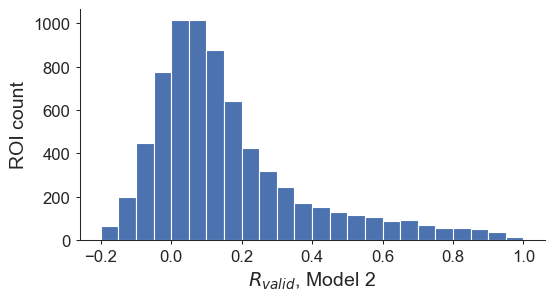

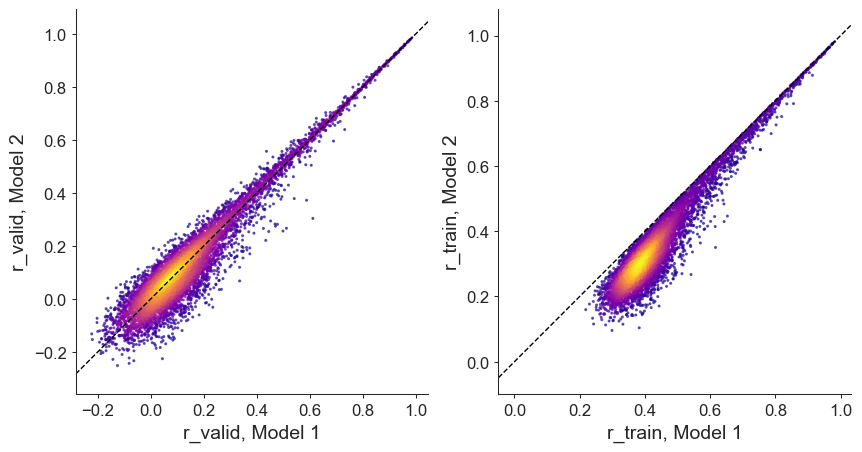

In [577]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(model_2_df.r_valid, bins=np.arange(-0.2, 1.05, 0.05))
ax.set_xlabel("$R_{valid}$, Model 2")
ax.set_ylabel("ROI count")

models_12_df = pd.merge(model_1_df, model_2_df, how="inner", on="roi_id", suffixes=["_model1", "_model2"])

fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

for ax, met in zip(axs, ("r_valid", "r_train")):
    at.density_scatter(models_12_df[f"{met}_model1"], models_12_df[f"{met}_model2"], s=2, ax=ax)
    ax.set_xlabel(f"{met}, Model 1")
    ax.set_ylabel(f"{met}, Model 2")
    ax.axis("equal")
    ax.axline((0, 0), slope=1, color="black", linestyle="dashed", linewidth=1)

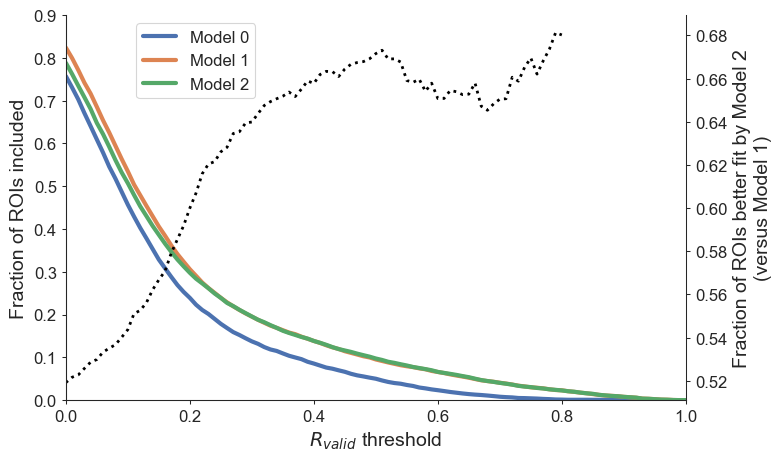

In [326]:
# How does fit compare between models?
fig, ax_frac_incl = plt.subplots(figsize=(8, 5))

r_thresh = np.arange(0, 1.01, 0.01)
ax_frac_incl.plot(r_thresh, [(model_combined_df.r_valid > r).mean() for r in r_thresh], linewidth=3, label="Model 0")
ax_frac_incl.plot(r_thresh, [(model_uncombined_df.r_valid > r).mean() for r in r_thresh], linewidth=3, label="Model 1")
ax_frac_incl.plot(r_thresh, [(model_tuning_gain_df.r_valid > r).mean() for r in r_thresh], linewidth=3, label="Model 2")
ax_frac_incl.set_xlabel("$R_{valid}$ threshold")
ax_frac_incl.set_ylabel("Fraction of ROIs included")
ax_frac_incl.set_xlim(r_thresh.min(), r_thresh.max())
ax_frac_incl.set_ylim(0, 0.9)

ax_frac_incl.legend(loc="upper left")
ax_frac_incl.legend(loc="upper left", bbox_to_anchor=(0.1, 1), bbox_transform=ax_frac_incl.transAxes)

ax_model_2_better = ax_frac_incl.twinx()
is_model_2_better = models_12_df.r_valid_model2 > models_12_df.r_valid_model1
r_thresh = r_thresh[:-20] # funky stuff happens near end
ax_model_2_better.plot(r_thresh, [is_model_2_better[(models_12_df.r_valid_model1 >= r) | (models_12_df.r_valid_model2 >= r)].mean() for r in r_thresh], color="black", linewidth=2, linestyle="dotted")
ax_model_2_better.set_ylabel("Fraction of ROIs better fit by Model 2\n(versus Model 1)")
ax_model_2_better.spines["right"].set_visible(True)

(0.0, 1.0)

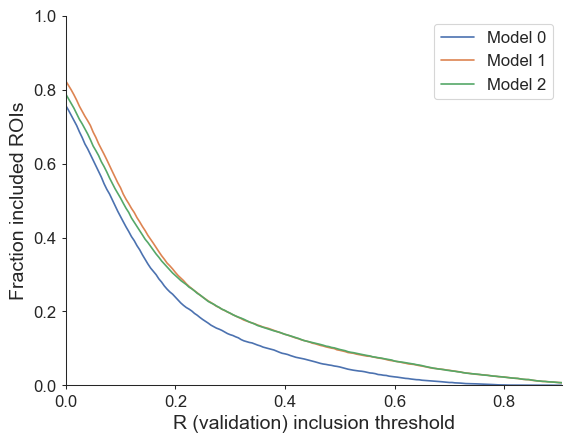

In [162]:
x = np.arange(0, 0.91, 0.005)

for model, df in enumerate((model_combined_df, model_uncombined_df, model_tuning_gain_df)):
    plt.plot(x, [(df.r_valid >= xx).mean() for xx in x], label=f"Model {model}")

plt.xlabel("R (validation) inclusion threshold")
plt.ylabel("Fraction included ROIs")
plt.legend()
plt.xlim(x.min(), x.max())
plt.ylim(0, 1)

In [344]:
# Compute SSI
g = model_tuning_gain_df.weights.apply(itemgetter(-1)).values
model_tuning_gain_df["model_ssi"] = (1-g)/(1+g)

(-1.0, 1.0)

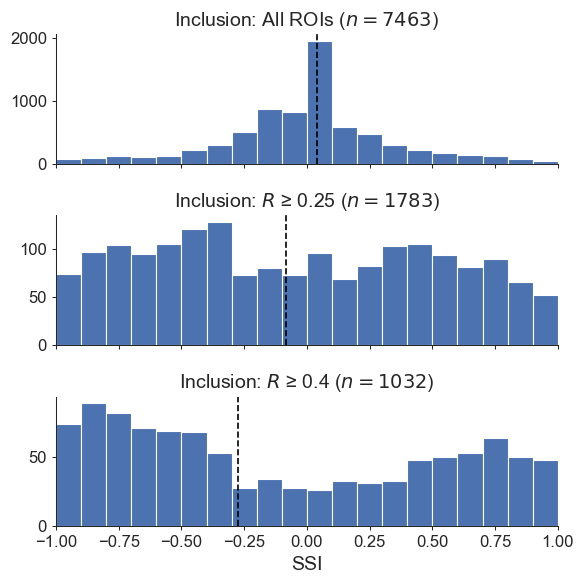

In [350]:
r_threshs = [None, 0.25, 0.4]
fig, axs = plt.subplots(figsize=(6, 2*len(r_threshs)), nrows=len(r_threshs), sharex=True, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)

for ax, r_thresh in zip(axs, r_threshs):
    ssi = model_tuning_gain_df["model_ssi"]
    if r_thresh is not None:
        ssi = ssi[model_tuning_gain_df.r_valid >= r_thresh]
    ax.set_title(f"Inclusion: {'All ROIs' if r_thresh is None else f'$R$ ≥ {r_thresh}'} ($n = {len(ssi)}$)")
    ax.hist(ssi, bins=bins)
    ax.axvline(x=np.median(ssi), color="black", linestyle="dashed")

axs[-1].set_xlabel("SSI")
axs[-1].set_xlim(-1, 1)

Text(0.5, 0.98, 'Windowed = darkred, Full = darkblue')

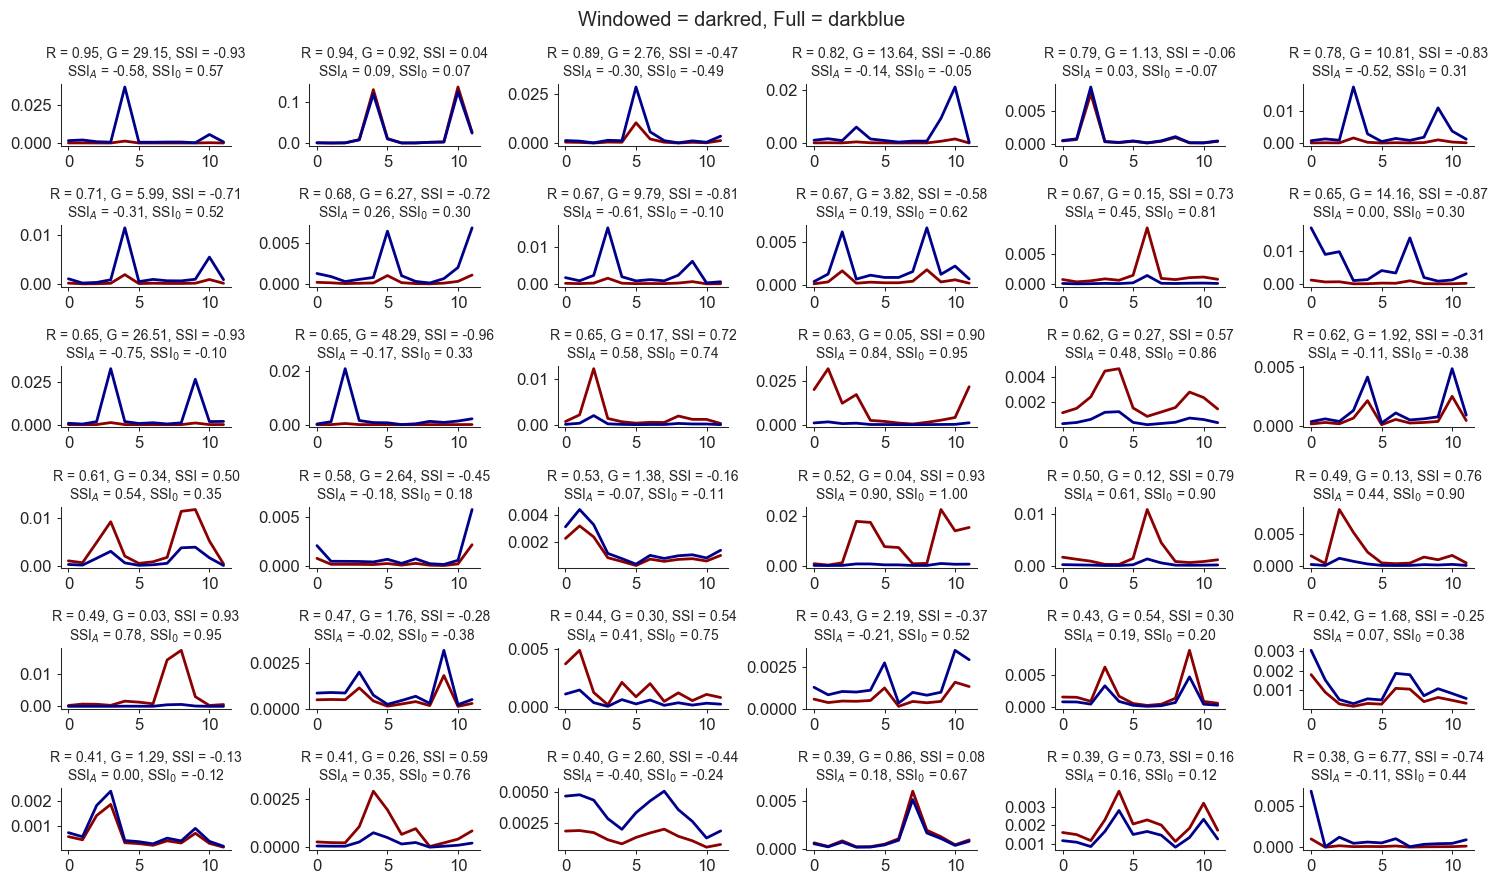

In [370]:
# Plot out sample responses
nrows, ncols = 6, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5*ncols, 1.5*nrows), tight_layout=True) # sharey="all"
valid_idx = model_tuning_gain_df.index[model_tuning_gain_df.r_valid >= 0.35]
valid_idx = np.random.choice(valid_idx, size=nrows*ncols, replace=False)
df = model_tuning_gain_df[model_tuning_gain_df.index.isin(valid_idx)].sort_values("r_valid", ascending=False)

for i, ax in enumerate(axs.flat):
    row = df.iloc[i]
    ax.plot(row.tuning_curves[:12], color="darkred", lw=2)
    ax.plot(row.tuning_curves[12:], color="darkblue", lw=2)
    ssi_avg = metrics_df.ssi_avg[metrics_df.roi_id == row.roi_id].values[0]
    ssi_old = metrics_df.ssi[metrics_df.roi_id == row.roi_id].values[0]
    ax.set_title(f"R = {row.r_valid:.2f}, G = {row.weights[-1]:.2f}, SSI = {row.model_ssi:.2f}\nSSI$_A$ = {ssi_avg:.2f}, SSI$_0$ = {ssi_old:.2f}", fontsize=10)

fig.suptitle("Windowed = darkred, Full = darkblue")

Text(0, 0.5, 'SSI (from avg. resp. across dir.)')

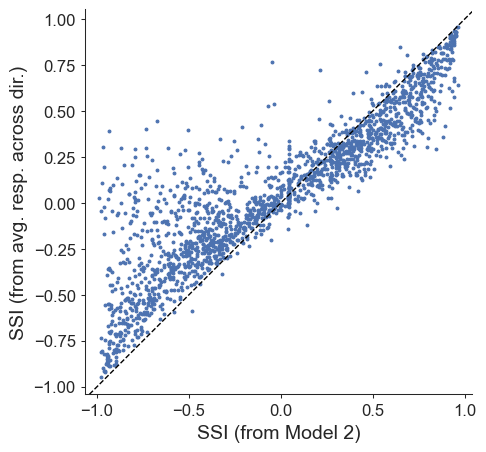

In [362]:
d = pd.merge(model_tuning_gain_df, metrics_df, how="left", on="roi_id")
d = d[d.r_valid >= 0.25]
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(d.model_ssi, d.ssi_avg, s=4)
ax.axis("equal")
ax.axline((0, 0), slope=1, color="black", linestyle="dashed", linewidth=1)
ax.set_xlabel("SSI (from Model 2)")
ax.set_ylabel("SSI (from avg. resp. across dir.)")

In [712]:
df = pd.merge(left=model_tuning_gain_fit_df, right=metrics_df, on="roi_id", how="left")
df["model_ssi"] = df["weights"].apply(lambda w: (1 - w[-1]) / (1 + w[-1]))
df

roi_id  r2_train   r2_test   r_train    r_test     mse_train  \
0      M409828_11_0_89  0.089410 -0.140781  0.297493  0.081027  3.171946e-07   
1       M409828_11_1_2  0.073995 -0.032239  0.270030  0.126642  6.270529e-07   
2     M409828_11_1_159  0.213834  0.011088  0.461256  0.283499  6.872393e-07   
3       M409828_11_2_0  0.578184  0.320347  0.759930  0.668828  1.388635e-04   
4       M409828_11_2_1  0.577361 -1.367725  0.758664  0.675532  1.134970e-04   
...                ...       ...       ...       ...       ...           ...   
2682   M409828_1f_0_21  0.307723 -0.243771  0.555269  0.472756  3.519453e-06   
2683   M409828_1f_0_26  0.222107 -0.056775  0.471395  0.272222  3.416460e-06   
2684   M409828_1f_0_32  0.326033 -0.120232  0.570577  0.405751  2.876264e-05   
2685   M409828_1f_0_38  0.252477 -0.046396  0.509194  0.395958  3.856541e-06   
2686   M409828_1f_0_70  0.242250 -0.297943  0.491930  0.300088  6.307817e-05   

          mse_test                                            weights  \
0     3.744273e-07  [0.0006295487882331003, 0.00043830084218430377...   
1     6.925614e-07  [0.0009963625956974224, 0.0008521320141568742,...   
2     8.383668e-07  [0.0009466679277831509, 0.0009503727307473873,...   
3     1.951087e-04  [0.00929064104782536, 0.008582400293593992, 0....   
4     1.552204e-04  [0.0008563414949271217, 0.011674691985054173, ...   
...            ...                                                ...   
2682  4.409279e-06  [0.0003065425417439014, 0.0008925943076676598,...   
2683  4.427707e-06  [0.0006872491325533612, 0.00041450247674691286...   
2684  3.910337e-05  [0.0008006455357443831, 0.0003328168779152708,...   
2685  4.712707e-06  [0.00031490854771358854, 0.0003115916200061297...   
2686  8.527405e-05  [0.000986172749738988, 0.0004678167522775255, ...   

                                            predictions  frac_resp_trials_w  \
0     [0.0006295487882331003, 0.00043830084218430377...            0.375000   
1     [0.0009963625956974224, 0.0008521320141568742,...            0.500000   
2     [0.0009466679277831509, 0.0009503727307473873,...            0.500000   
3     [0.00929064104782536, 0.008582400293593992, 0....            0.714286   
4     [0.0008563414949271217, 0.011674691985054173, ...            1.000000   
...                                                 ...                 ...   
2682  [0.0003065425417439014, 0.0008925943076676598,...            0.500000   
2683  [0.0006872491325533612, 0.00041450247674691286...            0.250000   
2684  [0.0008006455357443831, 0.0003328168779152708,...            0.142857   
2685  [0.00031490854771358854, 0.0003115916200061297...            0.125000   
2686  [0.000986172749738988, 0.0004678167522775255, ...            0.142857   

      frac_resp_trials_f  pref_sf_idx_w  pref_sf_idx_f   dgw_dsi  dgw_dsi_p  \
0               0.500000              0              1  0.147405      0.209   
1               0.625000              0              0  0.276517      0.001   
2               0.250000              0              0  0.119700      0.200   
3               0.875000              1              1  0.601165      0.003   
4               0.500000              1              1  0.473892      0.000   
...                  ...            ...            ...       ...        ...   
2682            0.428571              1              1  0.266987      0.090   
2683            0.500000              1              0  0.119435      0.652   
2684            0.625000              0              0  0.448160      0.002   
2685            0.625000              0              0  0.041378      0.934   
2686            0.625000              0              1  0.204045      0.222   

       dgf_dsi  dgf_dsi_p       ssi   ssi_avg  model_ssi  
0     0.182444      0.183  0.253797  0.036927   0.041811  
1     0.074370      0.775  0.534480  0.069366   0.043550  
2     0.191448      0.126  0.479005  0.280201   0.258070  
3     0.024593      0.980 -0.142808 -0.60165

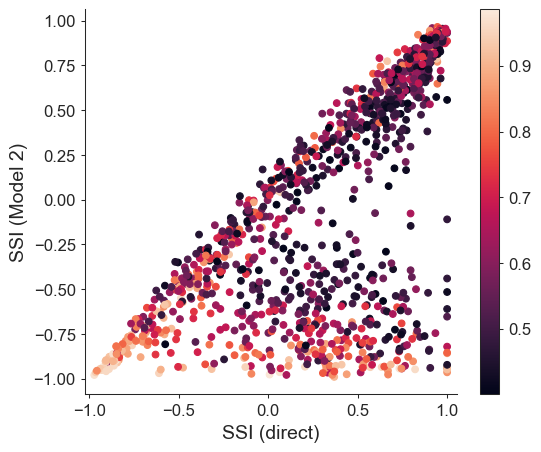

In [713]:
fig, ax = plt.subplots(figsize=(6, 5))
mask = df.r_test > 0.4
s = ax.scatter(df["ssi"][mask], df["model_ssi"][mask], c=df["r_test"][mask])
ax.set_xlabel("SSI (direct)")
ax.set_ylabel("SSI (Model 2)")
ax.axis("equal")
plt.colorbar(s)

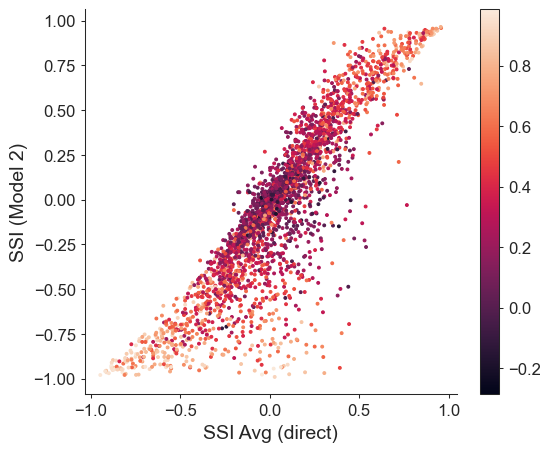

In [716]:
fig, ax = plt.subplots(figsize=(6, 5))
mask = df.r_test > -10
s = ax.scatter(df["ssi_avg"][mask], df["model_ssi"][mask], c=df["r_test"][mask], s=4)
ax.set_xlabel("SSI Avg (direct)")
ax.set_ylabel("SSI (Model 2)")
ax.axis("equal")
plt.colorbar(s)

<Axes: >

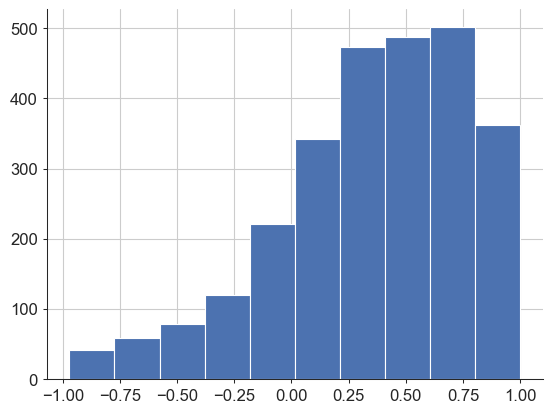

In [696]:
df.ssi.hist()

<Axes: xlabel='depth', ylabel='r_valid'>

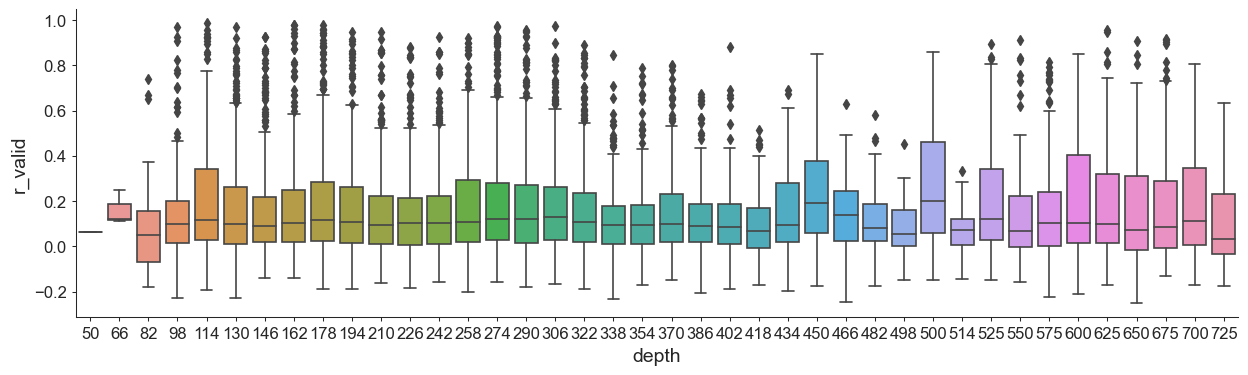

In [178]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=model_tuning_gain_df, x="depth", y="r_valid")
# sns.boxplot(data=model_tuning_gain_df[model_tuning_gain_df.r_valid >= 0.25], x="depth", y="r_valid")
# sns.countplot(data=model_tuning_gain_df, x="depth")

In [725]:
df

roi_id  r2_train   r2_test   r_train    r_test     mse_train  \
0      M409828_11_0_89  0.089410 -0.140781  0.297493  0.081027  3.171946e-07   
1       M409828_11_1_2  0.073995 -0.032239  0.270030  0.126642  6.270529e-07   
2     M409828_11_1_159  0.213834  0.011088  0.461256  0.283499  6.872393e-07   
3       M409828_11_2_0  0.578184  0.320347  0.759930  0.668828  1.388635e-04   
4       M409828_11_2_1  0.577361 -1.367725  0.758664  0.675532  1.134970e-04   
...                ...       ...       ...       ...       ...           ...   
2682   M409828_1f_0_21  0.307723 -0.243771  0.555269  0.472756  3.519453e-06   
2683   M409828_1f_0_26  0.222107 -0.056775  0.471395  0.272222  3.416460e-06   
2684   M409828_1f_0_32  0.326033 -0.120232  0.570577  0.405751  2.876264e-05   
2685   M409828_1f_0_38  0.252477 -0.046396  0.509194  0.395958  3.856541e-06   
2686   M409828_1f_0_70  0.242250 -0.297943  0.491930  0.300088  6.307817e-05   

          mse_test                                            weights  \
0     3.744273e-07  [0.0006295487882331003, 0.00043830084218430377...   
1     6.925614e-07  [0.0009963625956974224, 0.0008521320141568742,...   
2     8.383668e-07  [0.0009466679277831509, 0.0009503727307473873,...   
3     1.951087e-04  [0.00929064104782536, 0.008582400293593992, 0....   
4     1.552204e-04  [0.0008563414949271217, 0.011674691985054173, ...   
...            ...                                                ...   
2682  4.409279e-06  [0.0003065425417439014, 0.0008925943076676598,...   
2683  4.427707e-06  [0.0006872491325533612, 0.00041450247674691286...   
2684  3.910337e-05  [0.0008006455357443831, 0.0003328168779152708,...   
2685  4.712707e-06  [0.00031490854771358854, 0.0003115916200061297...   
2686  8.527405e-05  [0.000986172749738988, 0.0004678167522775255, ...   

                                            predictions  frac_resp_trials_w  \
0     [0.0006295487882331003, 0.00043830084218430377...            0.375000   
1     [0.0009963625956974224, 0.0008521320141568742,...            0.500000   
2     [0.0009466679277831509, 0.0009503727307473873,...            0.500000   
3     [0.00929064104782536, 0.008582400293593992, 0....            0.714286   
4     [0.0008563414949271217, 0.011674691985054173, ...            1.000000   
...                                                 ...                 ...   
2682  [0.0003065425417439014, 0.0008925943076676598,...            0.500000   
2683  [0.0006872491325533612, 0.00041450247674691286...            0.250000   
2684  [0.0008006455357443831, 0.0003328168779152708,...            0.142857   
2685  [0.00031490854771358854, 0.0003115916200061297...            0.125000   
2686  [0.000986172749738988, 0.0004678167522775255, ...            0.142857   

      frac_resp_trials_f  pref_sf_idx_w  pref_sf_idx_f   dgw_dsi  dgw_dsi_p  \
0               0.500000              0              1  0.147405      0.209   
1               0.625000              0              0  0.276517      0.001   
2               0.250000              0              0  0.119700      0.200   
3               0.875000              1              1  0.601165      0.003   
4               0.500000              1              1  0.473892      0.000   
...                  ...            ...            ...       ...        ...   
2682            0.428571              1              1  0.266987      0.090   
2683            0.500000              1              0  0.119435      0.652   
2684            0.625000              0              0  0.448160      0.002   
2685            0.625000              0              0  0.041378      0.934   
2686            0.625000              0              1  0.204045      0.222   

       dgf_dsi  dgf_dsi_p       ssi   ssi_avg  model_ssi  
0     0.182444      0.183  0.253797  0.036927   0.041811  
1     0.074370      0.775  0.534480  0.069366   0.043550  
2     0.191448      0.126  0.479005  0.280201   0.258070  
3     0.024593      0.980 -0.142808 -0.60165

# Model 3
Fit a single tuning curve across DG conditions and use a multiplicative gain term to model the gain for different DG sizes and a multiplicative gain term to model running modulation. The trials are encoded into feature vectors $x_i \in \mathbb{R}^{12}$ as follows:
$$x_i = \begin{bmatrix} \underbrace{0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0}_\text{One-hot direction encoding}, \underbrace{0}_\text{0 = DGW, 1 = DGF}, \underbrace{1}_\text{0 = stationary, 1 = running} \end{bmatrix}$$
Let $w \in \mathbb{R}^{14}$ denote model weights and define the superscript $^{(D)}$ on $w$ or $x_i$ to denote the first 12 elements (encoding direction), $^{(S)}$ to denote the second-to-last element (encoding size), and $^{(L)}$ to denote the last element (encoding locomotion). The prediction for trial $i$ is then
$$\begin{align*}
    \hat{y}_i &= (x_i^{(D)} \cdot w^{(D)}) \times \begin{cases}
        1 & \text{if } x_i^{(S)} = 0 \\
        w^{(S)} & \text{otherwise}
    \end{cases} \times \begin{cases}
        1 & \text{if } x_i^{(L)} = 0 \\
        w^{(L)} & \text{otherwise}
    \end{cases} \\
    &= (x_i^{(D)} \cdot w^{(D)}) (x_i^{(S)}w^{(S)} + (1 - x_i^{(S)})) (x_i^{(L)}w^{(L)} + (1 - x_i^{(L)}))
\end{align*}$$
which effectively scales the direction tuning curve for different sized DG stimuli. The optimal weights $w$ are solved by minimizing the sum of squares between predicted ($\hat{y}_i$) and true ($y_i$) responses:
$$L(w) = \sum_{i} (y_i - \hat{y}_i)^2$$

In [24]:
model_3 = DGModelSimpleTuningSizeRunningGain()
model_3.solver_method = "CG"
model_3_save_file = path.join(MODEL_SAVE_DIRECTORY, "model_3_cg.csv")
# model_3_df = train_and_evaluate(model_3, plane_group_filter=dict(mouse=409828, column=1), kfold_splitter_fn=kfold_splitter_fn, debug=False, suppress_warnings=True, save_file=model_3_save_file)
model_3_df = pd.read_csv(model_3_save_file)
model_3_df

roi_id   r_valid    r_test     r2_valid      r2_test  \
0      M409828_11_0_89 -0.024927 -0.040589  -470.592150    -0.157745   
1       M409828_11_1_2  0.083560  0.048008 -1671.726358 -1293.566765   
2       M409828_11_1_4 -0.038343 -0.086970 -4451.440020 -3804.392117   
3     M409828_11_1_159 -0.059009 -0.111985 -1255.335404 -1082.115407   
4       M409828_11_2_0  0.899376  0.902960     0.649126     0.671200   
...                ...       ...       ...          ...          ...   
7450   M409828_1f_0_67  0.190694  0.211189    -0.081716    -0.038230   
7451   M409828_1f_0_69  0.221537  0.267816    -0.206074    -0.179367   
7452   M409828_1f_0_70  0.289474  0.311626    -0.199867    -0.084543   
7453   M409828_1f_0_74  0.186893  0.193379    -0.087262    -0.062877   
7454   M409828_1f_0_90  0.036126  0.051718    -0.160997    -0.120463   

      mse_valid      mse_test  expl_var_valid  expl_var_test   r_train  \
0      0.000117  3.944514e-07     -456.829534      -0.130841  0.312923   
1      0.001115  8.628688e-04    -1615.234172   -1253.358826  0.257028   
2      0.001036  8.379174e-04    -4303.135913   -3690.212965  0.051693   
3      0.000960  8.235412e-04    -1214.367098   -1048.680205  0.165328   
4      0.000109  1.023041e-04        0.652960       0.674471  0.924349   
...         ...           ...             ...            ...       ...   
7450   0.000004  3.749098e-06       -0.047914      -0.007757  0.398025   
7451   0.000014  1.336324e-05       -0.137599      -0.119677  0.404142   
7452   0.000095  8.943338e-05       -0.186310      -0.072784  0.508605   
7453   0.000003  2.748373e-06       -0.079144      -0.055125  0.396498   
7454   0.000005  4.522636e-06       -0.143299      -0.103762  0.307923   

      r2_train     mse_train  expl_var_train  \
0     0.097623  3.153483e-07        0.097667   
1     0.065646  6.329696e-07        0.065692   
2    -0.514208  5.421173e-07       -0.064715   
3    -0.596757  1.398320e-06       -0.084186   
4     0.854377  4.821525e-05        0.854412   
...        ...           ...             ...   
7450  0.158402  3.053158e-06        0.158407   
7451  0.163328  1.048601e-05        0.163329   
7452  0.258276  6.161717e-05        0.258514   
7453  0.156891  2.205409e-06        0.156992   
7454  0.094138  3.699846e-06        0.094244   

                                                weights  \
0     [0.0006544303015569352, 0.00037188825989638074...   
1     [0.001198540046147324, 0.0010305626966746128, ...   
2     [0.00038990558656194394, 0.0008795302908670646...   
3     [0.0007165469398892954, 0.001146326916560819, ...   
4     [0.004516212071309472, 0.005753867350348473, 0...   
...                                                 ...   
7450  [0.000662150525325409, 0.0005373809987150556, ...   
7451  [0.0009468485043175615, 0.00041988100384622443...   
7452  [0.002073853468473667, 0.0005226637342123577, ...   
7453  [0.0005555719278421421, 0.0006916851689040645,...   
7454  [0.0007492542500354028, 0.0015136546310081014,...   

                                      dgw_tuning_curves  \
0     [0.0006544303015569352, 0.00037188825989638074...   
1     [0.001198540046147324, 0.0010305626966746128, ...   
2     [0.00038990558656194394, 0.0008795302908670646...   
3     [0.0007165469398892954, 0.001146326916560819, ...   
4     [0.004516212071309472, 0.005753867350348473, 0...   
...                                                 ...   
7450  [0.000662150525325409, 0.0005373809987150556, ...   
7451  [0.0009468485043175615, 0.00041988100384622443...   
7452  [0.002073853468473667, 0.0005226637342123577, ...   
7453  [0.0005555719278421421, 0.0006916851689040645,...   
7454  [0.0007492542500354028, 0.0015136546310081014,...   

                                      dgf_tuning_curves  
0     [0.0004578198035256006, 0.0002601618685354015,...  
1     [0.0009678792287540752, 0.0008322293704298445,...  
2     [3.984884928278096e-06, 8.988911984936147e-06,...  
3     [-1.4238556421108987e-06, -2.

In [25]:
model_3_null_df_save_file = path.join(MODEL_SAVE_DIRECTORY, "model_3_null.csv")
model_3_null_df = build_fit_null_distribution(model_3, plane_group_filter=plane_group_filter, n_shuffles=100, suppress_warnings=True, save_file=model_3_null_df_save_file)
model_3_null_df = pd.read_csv(model_3_null_df_save_file)
model_3_null_df

M409828_11_0:   0%|          | 0/1 [00:00<?, ?it/s]

Processed 1/1 ROIs in M409828_11_0 (1 total)


M409828_11_1:   0%|          | 0/3 [00:00<?, ?it/s]

Processed 3/3 ROIs in M409828_11_1 (4 total)


M409828_11_2:   0%|          | 0/23 [00:00<?, ?it/s]

Processed 23/23 ROIs in M409828_11_2 (27 total)


M409828_11_3:   0%|          | 0/93 [00:00<?, ?it/s]

Processed 93/93 ROIs in M409828_11_3 (120 total)


M409828_11_4:   0%|          | 0/176 [00:00<?, ?it/s]

Processed 176/176 ROIs in M409828_11_4 (296 total)


M409828_11_5:   0%|          | 0/234 [00:00<?, ?it/s]

Processed 234/234 ROIs in M409828_11_5 (530 total)


M409828_12_0:   0%|          | 0/254 [00:00<?, ?it/s]

Processed 252/254 ROIs in M409828_12_0 (782 total)


M409828_12_1:   0%|          | 0/234 [00:00<?, ?it/s]

Processed 226/234 ROIs in M409828_12_1 (1008 total)


M409828_12_2:   0%|          | 0/281 [00:00<?, ?it/s]

Processed 257/281 ROIs in M409828_12_2 (1265 total)


M409828_12_3:   0%|          | 0/213 [00:00<?, ?it/s]

Processed 202/213 ROIs in M409828_12_3 (1467 total)


M409828_12_4:   0%|          | 0/276 [00:00<?, ?it/s]

Processed 267/276 ROIs in M409828_12_4 (1734 total)


M409828_12_5:   0%|          | 0/306 [00:00<?, ?it/s]

Processed 300/306 ROIs in M409828_12_5 (2034 total)


M409828_13_0:   0%|          | 0/301 [00:00<?, ?it/s]

Processed 299/301 ROIs in M409828_13_0 (2333 total)


M409828_13_1:   0%|          | 0/268 [00:00<?, ?it/s]

Processed 264/268 ROIs in M409828_13_1 (2597 total)


M409828_13_2:   0%|          | 0/386 [00:00<?, ?it/s]

Processed 367/386 ROIs in M409828_13_2 (2964 total)


M409828_13_3:   0%|          | 0/273 [00:00<?, ?it/s]

Processed 271/273 ROIs in M409828_13_3 (3235 total)


M409828_13_4:   0%|          | 0/305 [00:00<?, ?it/s]

Processed 305/305 ROIs in M409828_13_4 (3540 total)


M409828_13_5:   0%|          | 0/368 [00:00<?, ?it/s]

Processed 368/368 ROIs in M409828_13_5 (3908 total)


M409828_14_0:   0%|          | 0/368 [00:00<?, ?it/s]

Processed 368/368 ROIs in M409828_14_0 (4276 total)


M409828_14_1:   0%|          | 0/327 [00:00<?, ?it/s]

Processed 326/327 ROIs in M409828_14_1 (4602 total)


M409828_14_2:   0%|          | 0/367 [00:00<?, ?it/s]

Processed 364/367 ROIs in M409828_14_2 (4966 total)


M409828_14_3:   0%|          | 0/214 [00:00<?, ?it/s]

Processed 213/214 ROIs in M409828_14_3 (5179 total)


M409828_14_4:   0%|          | 0/165 [00:00<?, ?it/s]

Processed 164/165 ROIs in M409828_14_4 (5343 total)


M409828_14_5:   0%|          | 0/172 [00:00<?, ?it/s]

Processed 172/172 ROIs in M409828_14_5 (5515 total)


M409828_15_0:   0%|          | 0/129 [00:00<?, ?it/s]

Processed 129/129 ROIs in M409828_15_0 (5644 total)


M409828_15_1:   0%|          | 0/189 [00:00<?, ?it/s]

Processed 189/189 ROIs in M409828_15_1 (5833 total)


M409828_15_2:   0%|          | 0/97 [00:00<?, ?it/s]

Processed 97/97 ROIs in M409828_15_2 (5930 total)


M409828_15_3:   0%|          | 0/80 [00:00<?, ?it/s]

Processed 80/80 ROIs in M409828_15_3 (6010 total)


M409828_15_4:   0%|          | 0/69 [00:00<?, ?it/s]

Processed 69/69 ROIs in M409828_15_4 (6079 total)


M409828_15_5:   0%|          | 0/121 [00:00<?, ?it/s]

Processed 121/121 ROIs in M409828_15_5 (6200 total)


M409828_16_0:   0%|          | 0/127 [00:00<?, ?it/s]

Processed 122/127 ROIs in M409828_16_0 (6322 total)


M409828_17_0:   0%|          | 0/120 [00:00<?, ?it/s]

Processed 117/120 ROIs in M409828_17_0 (6439 total)


M409828_18_0:   0%|          | 0/109 [00:00<?, ?it/s]

Processed 105/109 ROIs in M409828_18_0 (6544 total)


M409828_19_0:   0%|          | 0/130 [00:00<?, ?it/s]

Processed 130/130 ROIs in M409828_19_0 (6674 total)


M409828_1a_0:   0%|          | 0/154 [00:00<?, ?it/s]

Processed 152/154 ROIs in M409828_1a_0 (6826 total)


M409828_1b_0:   0%|          | 0/125 [00:00<?, ?it/s]

Processed 123/125 ROIs in M409828_1b_0 (6949 total)


M409828_1c_0:   0%|          | 0/127 [00:00<?, ?it/s]

Processed 125/127 ROIs in M409828_1c_0 (7074 total)


M409828_1d_0:   0%|          | 0/134 [00:00<?, ?it/s]

Processed 134/134 ROIs in M409828_1d_0 (7208 total)


M409828_1e_0:   0%|          | 0/112 [00:00<?, ?it/s]

Processed 112/112 ROIs in M409828_1e_0 (7320 total)


M409828_1f_0:   0%|          | 0/33 [00:00<?, ?it/s]

Processed 33/33 ROIs in M409828_1f_0 (7353 total)
Done


roi_id  shuffle         r        r2           mse  expl_var
0       M409828_11_0_89        0  0.198169  0.038544  3.359943e-07  0.038599
1       M409828_11_0_89        1  0.215264  0.045072  3.337130e-07  0.045188
2       M409828_11_0_89        2  0.258218  0.066391  3.262629e-07  0.066422
3       M409828_11_0_89        3  0.258729  0.065931  3.264237e-07  0.066051
4       M409828_11_0_89        4  0.085803  0.003043  3.484005e-07  0.003197
...                 ...      ...       ...       ...           ...       ...
735295  M409828_1f_0_90       95  0.282278  0.079564  3.759372e-06  0.079576
735296  M409828_1f_0_90       96  0.246436  0.060730  3.836297e-06  0.060730
735297  M409828_1f_0_90       97  0.267698  0.071661  3.791650e-06  0.071661
735298  M409828_1f_0_90       98  0.269200  0.072117  3.789786e-06  0.072160
735299  M409828_1f_0_90       99  0.221998  0.049280  3.883060e-06  0.049281

[735300 rows x 6 columns]

[0.05244246 0.06569912 0.04516736 0.00342854 0.00508897 0.05019229
 0.05894141 0.05177097 0.04189298 0.00464316 0.01095666 0.03823096
 0.06121121 0.07668449 0.05271967 0.00400181 0.00593989 0.0585848
 0.06879683 0.06042744 0.04889779 0.00541953 0.01278869 0.04462345
 0.00819595 0.01026776 0.00705896 0.00053583 0.00079533 0.00784428
 0.00921163 0.008091   0.00654723 0.00072565 0.00171236 0.00597491
 0.00956637 0.0119846  0.00823927 0.00062542 0.00092831 0.0091559
 0.01075188 0.00944388 0.00764197 0.00084699 0.00199867 0.00697396]


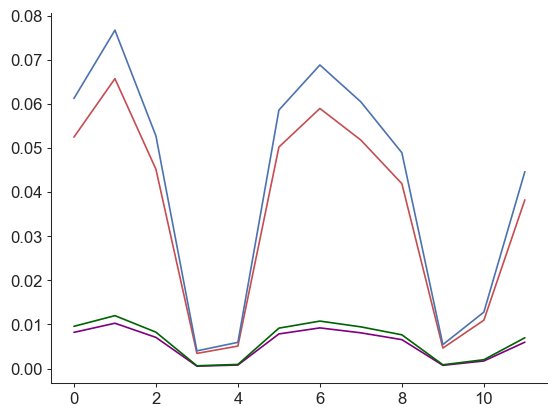

In [659]:
pred = model_3.predict(model_3._all_dg_X)
print(pred)
tcw = pred[:24]
tcf = pred[24:]
plt.plot(tcw[:12], c="r")
plt.plot(tcw[12:], c="b")
plt.plot(tcf[:12], c="purple")
plt.plot(tcf[12:], c="darkgreen")

Model 3 couldn't fit 9 ROIs


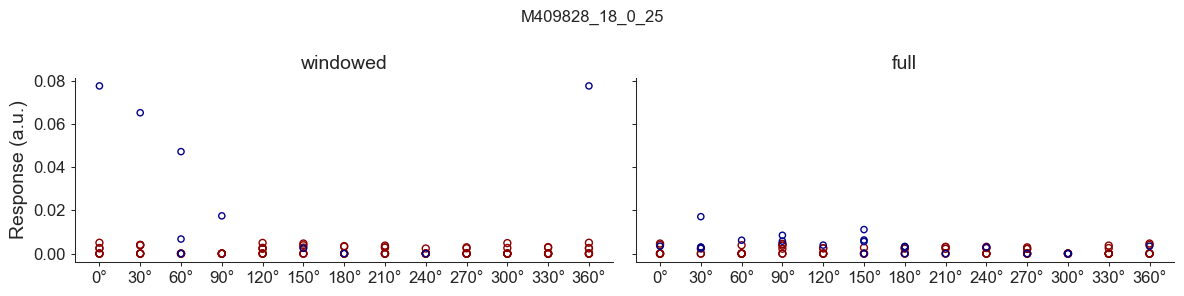

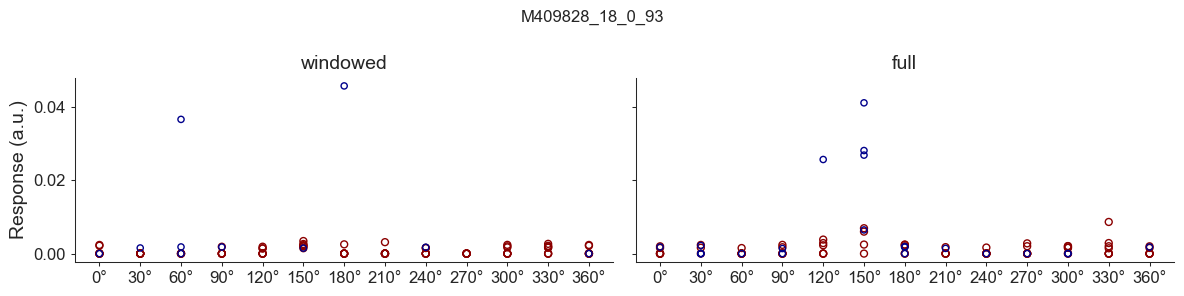

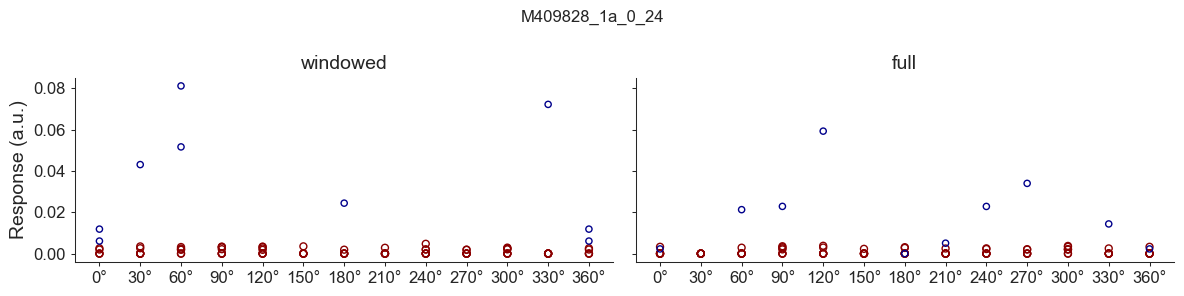

In [780]:
# Identify ROIs where Model 3 couldn't fit, and plot tuning curves
model_3_couldnt_fit = model_1_df.roi_id[~model_1_df.roi_id.isin(model_3_df.roi_id)].values
print(f"Model 3 couldn't fit {len(model_3_couldnt_fit)} ROIs")

# Plot random examples
for roi_id in np.random.choice(model_3_couldnt_fit, 3, replace=False):
    debug_plot_responses(roi_id)

# Merge all model dataframes together

In [48]:
merge_how = "outer"
models_df = None
model_filenames = {
    # 0: "model_0.csv",
    1: "model_1.csv",
    2: "model_2.csv",
    3: "model_3_cg.csv"
}

for m, filename in model_filenames.items():
    df = (
        pd.read_csv(path.join(MODEL_SAVE_DIRECTORY, filename))
        .set_index("roi_id")
        .rename(lambda c: f"{c}_model{m}", axis="columns") # add identifier to columns
    )

    print(f"Model {m} has fitted {len(df)} ROIs")

    if models_df is None:
        models_df = df
    else:
        models_df = pd.merge(models_df, df, how=merge_how, left_index=True, right_index=True)

models_df

Model 1 has fitted 7464 ROIs
Model 2 has fitted 7464 ROIs
Model 3 has fitted 7455 ROIs


r_valid_model1  r_test_model1  r2_valid_model1  \
roi_id                                                             
M409828_11_0_89         0.182259       0.202404        -0.189324   
M409828_11_1_159        0.220383       0.240981        -0.125890   
M409828_11_1_2          0.072252       0.093177        -0.176299   
M409828_11_1_4          0.158151       0.190637        -0.229978   
M409828_11_2_0          0.674335       0.692536         0.314975   
...                          ...            ...              ...   
M409828_1f_0_70         0.267908       0.288809        -0.420993   
M409828_1f_0_74         0.124498       0.141716        -0.210151   
M409828_1f_0_8          0.107009       0.125389        -0.398830   
M409828_1f_0_9          0.142399       0.170917        -0.140844   
M409828_1f_0_90         0.159889       0.175923        -0.124513   

                  r2_test_model1  mse_valid_model1  mse_test_model1  \
roi_id                                                                
M409828_11_0_89        -0.133236      3.936567e-07     3.750406e-07   
M409828_11_1_159       -0.067792      9.528576e-07     9.064121e-07   
M409828_11_1_2         -0.125405      7.820830e-07     7.490596e-07   
M409828_11_1_4         -0.167110      4.011714e-07     3.848406e-07   
M409828_11_2_0          0.351631      1.983765e-04     1.869085e-04   
...                          ...               ...              ...   
M409828_1f_0_70        -0.312254      8.924388e-05     8.567192e-05   
M409828_1f_0_74        -0.142545      3.076488e-06     2.925173e-06   
M409828_1f_0_8         -0.283620      3.554441e-06     3.343931e-06   
M409828_1f_0_9         -0.088498      1.741021e-06     1.663191e-06   
M409828_1f_0_90        -0.074929      4.526010e-06     4.326560e-06   

                  expl_var_valid_model1  expl_var_test_model1  r_train_model1  \
roi_id                                                                          
M409828_11_0_89               -0.086451             -0.037190        0.434485   
M409828_11_1_159              -0.119882             -0.062924        0.500370   
M409828_11_1_2                -0.159994             -0.110535        0.370460   
M409828_11_1_4                -0.178710             -0.119563        0.413210   
M409828_11_2_0                 0.336882              0.372815        0.783268   
...                                 ...                   ...             ...   
M409828_1f_0_70               -0.366339             -0.262666        0.467020   
M409828_1f_0_74               -0.194562             -0.127971        0.446726   
M409828_1f_0_8                -0.280016             -0.181731        0.402681   
M409828_1f_0_9                -0.129246             -0.078726        0.430352   
M409828_1f_0_90               -0.107482             -0.059346        0.422490   

                  r2_train_model1  ...  mse_test_model3  \
roi_id                             ...                    
M409828_11_0_89          0.188777  ...     3.944514e-07   
M409828_11_1_159         0.250370  ...     8.235412e-04   
M409828_11_1_2           0.137240  ...     8.628688e-04   
M409828_11_1_4           0.170742  ...     8.379174e-04   
M409828_11_2_0           0.613509  ...     1.023041e-04   
...                           ...  ...              ...   
M409828_1f_0_70          0.218108  ...     8.943338e-05   
M409828_1f_0_74          0.199564  ...     2.748373e-06   
M409828_1f_0_8           0.162152  ...     2.906461e-06   
M409828_1f_0_9           0.185203  ...     1.597240e-06   
M409828_1f_0_90          0.178498  ...     4.522636e-06   

                  expl_var_valid_model3 expl_var_test_model3  r_train_model3  \
roi_id                                                                         
M409828_11_0_89             -456.829534            -0.130841        0.312923   
M409828_11_1_159           -1214.367098         -1048.680205        0.165328   
M409828_11_1_2             -1615.234172         -1253.358826       

In [53]:
model_null_filenames = {
    1: "model_1_null.csv",
    2: "model_2_null.csv",
    3: "model_3_null.csv"
}

models_null_df = None

for m, filename in model_null_filenames.items():
    df = (
        pd.read_csv(path.join(MODEL_SAVE_DIRECTORY, filename))
        .drop("shuffle", axis="columns")
        .groupby("roi_id")
        .quantile(0.95)
        .rename(lambda c: f"{c}_null_model{m}", axis="columns")
    )

    print(f"Model {m} null DF has fitted {len(df)} ROIs")

    if models_null_df is None:
        models_null_df = df
    else:
        models_null_df = pd.merge(models_null_df, df, how=merge_how, left_index=True, right_index=True)

models_null_df

sig_fit_df = pd.DataFrame(index=models_df.index, columns=[f"model{m}" for m in model_filenames.keys()], data=False)
sig_fit_observed_metric = "r_train" # metric from models_df
sig_fit_null_metric = "r_null" # metric from models_null_df

# sig_fit_df[roi, model] is true iff sig_fit_observed_metric >= sig_fit_null_metric

for roi_id in models_df.index:
    if roi_id in models_null_df.index:
        for m in model_filenames.keys():
            model_key = f"model{m}"
            sig_fit_df.at[roi_id, model_key] = models_df.at[roi_id, f"{sig_fit_observed_metric}_{model_key}"] >= models_null_df.at[roi_id, f"{sig_fit_null_metric}_{model_key}"]

sig_fit_df

Model 1 null DF has fitted 7464 ROIs
Model 2 null DF has fitted 7464 ROIs
Model 3 null DF has fitted 7353 ROIs


r_null_model1  r2_null_model1  mse_null_model1  \
roi_id                                                             
M409828_11_0_89        0.430505        0.185334     3.213576e-07   
M409828_11_1_159       0.411209        0.169093     8.115301e-07   
M409828_11_1_2         0.432343        0.186922     6.275335e-07   
M409828_11_1_4         0.413407        0.170906     3.304991e-07   
M409828_11_2_0         0.434540        0.188825     3.035128e-04   
...                         ...             ...              ...   
M409828_1f_0_70        0.434044        0.188397     7.605688e-05   
M409828_1f_0_74        0.457387        0.209203     2.447478e-06   
M409828_1f_0_8         0.430094        0.184985     2.706601e-06   
M409828_1f_0_9         0.416631        0.173581     1.436192e-06   
M409828_1f_0_90        0.434479        0.188772     3.782055e-06   

                  expl_var_null_model1  r_null_model2  r2_null_model2  \
roi_id                                                                  
M409828_11_0_89               0.185334       0.307566        0.094441   
M409828_11_1_159              0.169093       0.318854        0.101400   
M409828_11_1_2                0.186922       0.307826        0.094750   
M409828_11_1_4                0.170906       0.342471        0.117282   
M409828_11_2_0                0.188825       0.352774        0.124104   
...                                ...            ...             ...   
M409828_1f_0_70               0.188397       0.347204        0.119945   
M409828_1f_0_74               0.209203       0.337627        0.113991   
M409828_1f_0_8                0.184985       0.312504        0.097648   
M409828_1f_0_9                0.173581       0.324813        0.105425   
M409828_1f_0_90               0.188772       0.319608        0.102098   

                  mse_null_model2  expl_var_null_model2  r_null_model3  \
roi_id                                                                   
M409828_11_0_89      3.395401e-07              0.094462       0.322399   
M409828_11_1_159     8.515405e-07              0.101430       0.328929   
M409828_11_1_2       6.631615e-07              0.094751       0.342044   
M409828_11_1_4       3.502284e-07              0.117283       0.341934   
M409828_11_2_0       3.197946e-04              0.124308       0.394070   
...                           ...                   ...            ...   
M409828_1f_0_70      7.983152e-05              0.120197       0.677601   
M409828_1f_0_74      2.561593e-06              0.113992       0.355852   
M409828_1f_0_8       2.878479e-06              0.097650       0.351544   
M409828_1f_0_9       1.516883e-06              0.105441       0.338986   
M409828_1f_0_90      3.975267e-06              0.102105       0.353528   

                  r2_null_model3  mse_null_model3  expl_var_null_model3  
roi_id                                                                   
M409828_11_0_89         0.103931     3.422121e-07              0.103933  
M409828_11_1_159        0.108177     1.471051e-06              0.108179  
M409828_11_1_2          0.115732     9.937861e-07              0.116154  
M409828_11_1_4          0.109989     5.282337e-07              0.109992  
M409828_11_2_0          0.148173     3.203533e-04              0.152322  
...                          ...              ...                   ...  
M409828_1f_0_70         0.396083     7.860930e-05              0.455136  
M409828_1f_0_74         0.120656     2.532863e-06              0.122753  
M409828_1f_0_8          0.123528     2.835539e-06              0.123541  
M409828_1f_0_9          0.114792     1.496420e-06              0.114821  
M409828_1f_0_90         0.124960     3.926772e-06              0.124963  

[7464 rows x 12 columns]

# Build a significant fit DF, containing information about which model fits which ROI

In [56]:
sig_fit_df = pd.DataFrame(index=models_df.index, columns=[f"model{m}" for m in model_filenames.keys()], data=False)
sig_fit_observed_metric = "r_train" # metric from models_df
sig_fit_null_metric = "r_null" # metric from models_null_df

# sig_fit_df[roi, model] is true iff sig_fit_observed_metric >= sig_fit_null_metric

for roi_id in models_df.index:
    if roi_id in models_null_df.index:
        for m in model_filenames.keys():
            model_key = f"model{m}"
            sig_fit_df.at[roi_id, model_key] = models_df.at[roi_id, f"{sig_fit_observed_metric}_{model_key}"] >= models_null_df.at[roi_id, f"{sig_fit_null_metric}_{model_key}"]

sig_fit_df

model1  model2  model3
roi_id                                  
M409828_11_0_89     True   False   False
M409828_11_1_159    True    True   False
M409828_11_1_2     False   False   False
M409828_11_1_4     False   False   False
M409828_11_2_0      True    True    True
...                  ...     ...     ...
M409828_1f_0_70     True    True   False
M409828_1f_0_74    False   False    True
M409828_1f_0_8     False   False    True
M409828_1f_0_9      True   False    True
M409828_1f_0_90    False   False   False

[7464 rows x 3 columns]

In [57]:
sig_fit_df.mean(axis=0)

model1    0.425509
model2    0.371249
model3    0.407690
dtype: float64

In [ ]:
# is_good_fit = pd.Series(index=model_1_null_df_aggr.index, data=False)
# metric = "r"

# for roi_id in model_1_null_df_aggr.index:
#     met_95pct = np.quantile(model_1_null_df_aggr.at[roi_id, metric], 0.95)
#     met_observed = mdf.at[roi_id, f"{metric}_train"]
#     # met_observed = mdf.at[roi_id, f"{metric}_valid"]
#     is_good_fit[roi_id] = met_observed >= met_95pct


# print(f"{is_good_fit.mean()*100:.1f}% ({is_good_fit.sum()}/{len(is_good_fit)}) ROIs are significantly fitted by model 1")

# # plt.figure(figsize=(10, 20))
# # for i, r2_bounds in enumerate(r2_peak.values):
# #     plt.plot(r2_bounds, [i, i], color="black")
# # plt.gca().invert_yaxis()
# # df_aggre()

In [847]:
def identify_best_model(metric, best="max", model_numbers=range(4)):
    # best_model = models_df[[f"{metric}_model{m}" for m in model_numbers]]
    best_model = models_df[[c for c in models_df.columns if c.startswith(metric)]]
    if best == "min":
        best_model = best_model.idxmin(axis="columns")
    else:
        best_model = best_model.idxmax(axis="columns")
    return (
        best_model.apply(lambda s: int(s[-1])) # get model number
        .rename(f"best_model_{metric}") # rename pd.Series
    )

best_model = identify_best_model("r2_valid", "max") # roi_id --> model_number
# best_model =  # roi_id --> model_number

print(identify_best_model("r2_valid", "max").value_counts(normalize=True).sort_index())
print()
print(identify_best_model("mse_valid", "min").value_counts(normalize=True).sort_index())

0    0.770230
1    0.037379
2    0.090300
3    0.102090
Name: best_model_r2_valid, dtype: float64

0    0.737808
1    0.063639
2    0.083601
3    0.114952
Name: best_model_mse_valid, dtype: float64


In [848]:
models_df.tuning_curves_model2.values[0]

'[0.0006288971815095078, 0.0004393697970746906, 0.0005969861197143338, 0.0005599719261539564, 0.0002933983804074397, 0.0003885712662490274, 0.0004242747775810787, 0.0003889782844321961, 0.00023290028185334567, 0.00053093416585052, 0.0005775751379989053, 0.0008561825646042109, 0.0005795773936062368, 0.00040491325021783464, 0.0005501688820621682, 0.0005160574399045348, 0.0002703892998799586, 0.000358098475147136, 0.0003910020222591661, 0.000358473573882966, 0.000214635622953065, 0.0004892968979150905, 0.0005322801611062828, 0.0007890384530796468]'

In [855]:
best_model

roi_id
M409828_11_0_89     0
M409828_11_1_2      2
M409828_11_1_4      0
M409828_11_1_159    2
M409828_11_2_0      3
                   ..
M409828_1f_0_67     0
M409828_1f_0_69     2
M409828_1f_0_70     3
M409828_1f_0_74     0
M409828_1f_0_90     0
Name: best_model_r2_valid, Length: 7464, dtype: int64

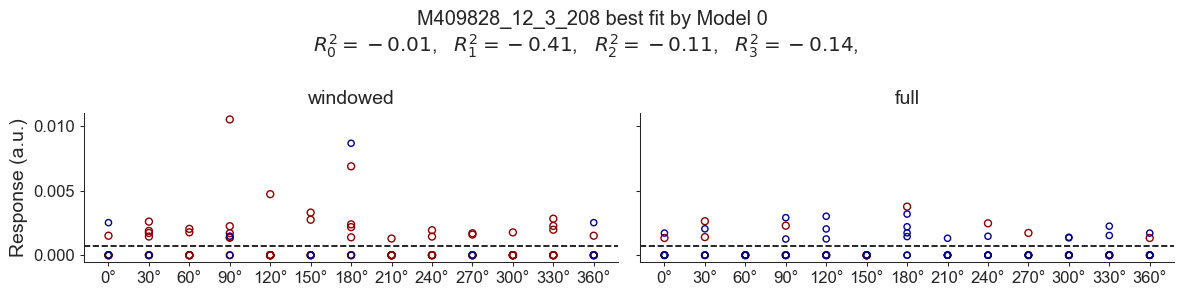

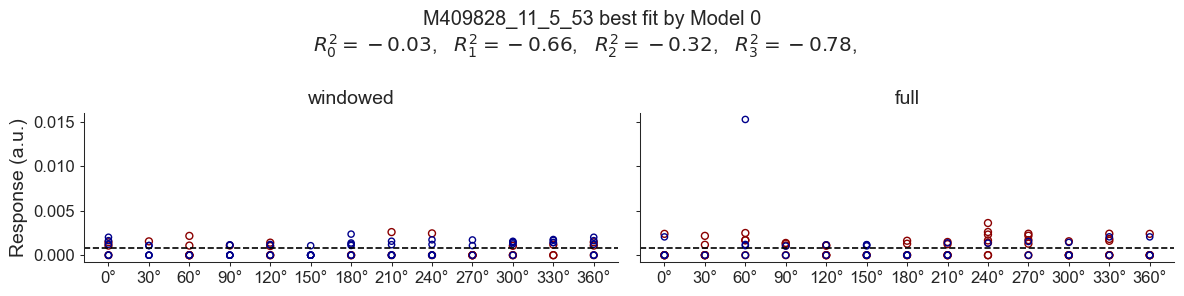

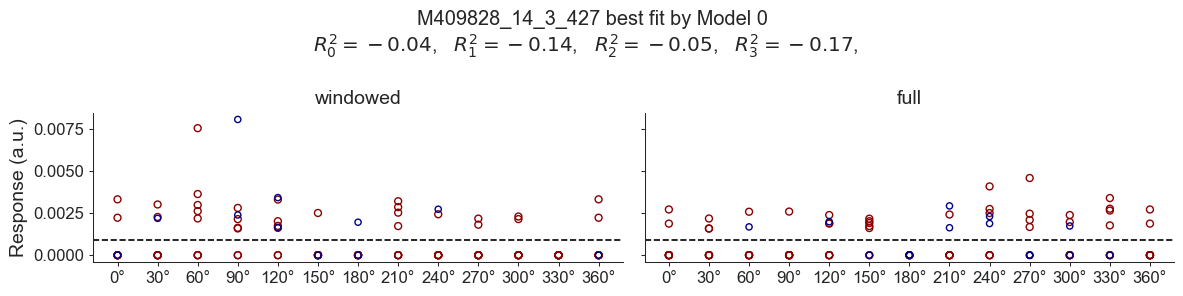

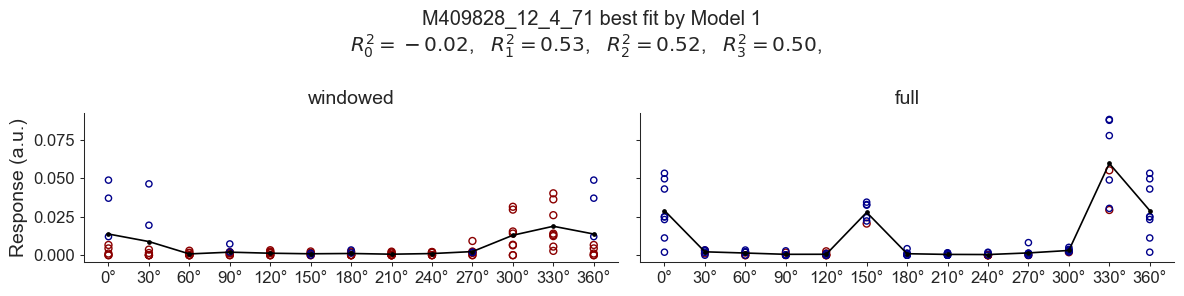

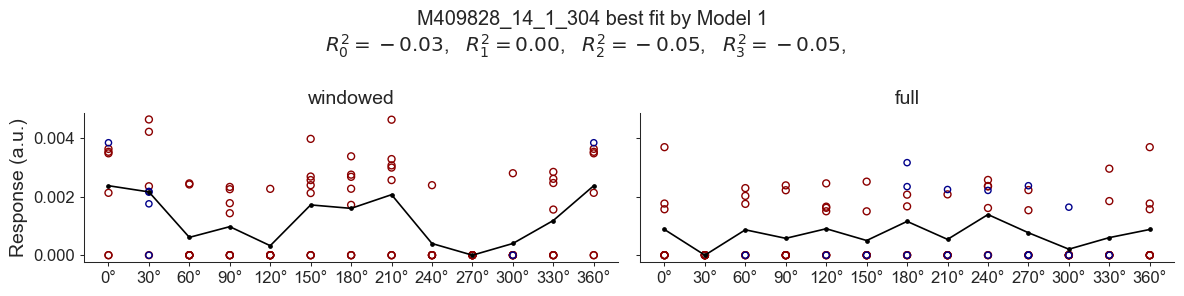

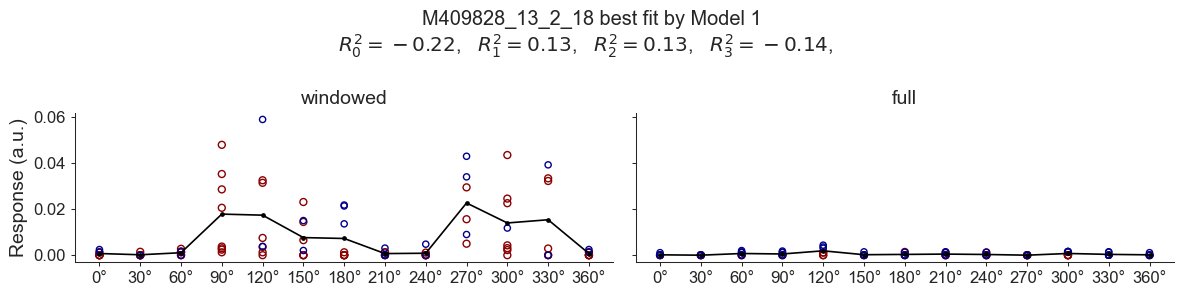

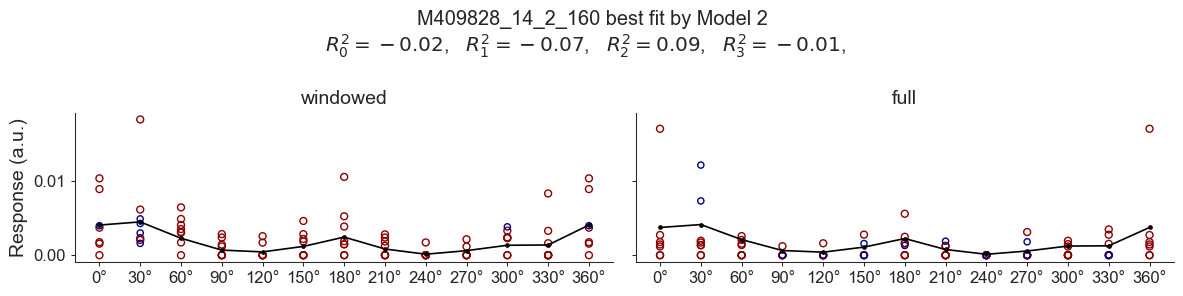

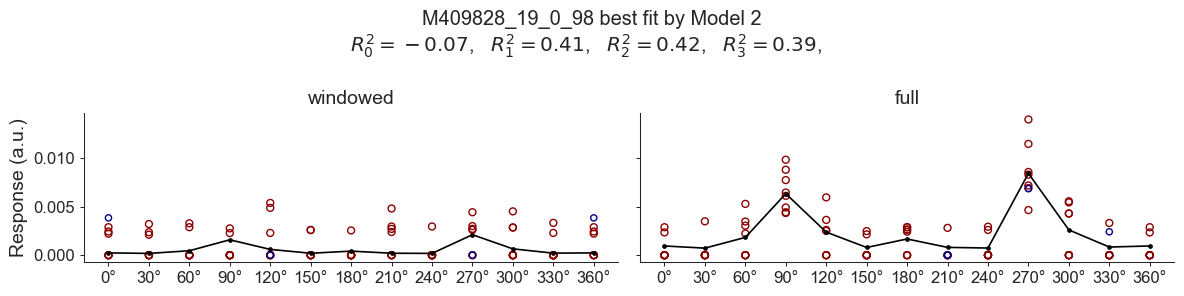

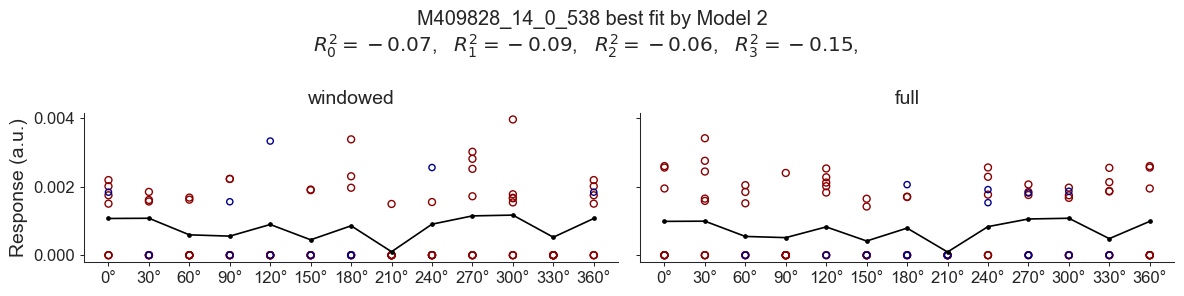

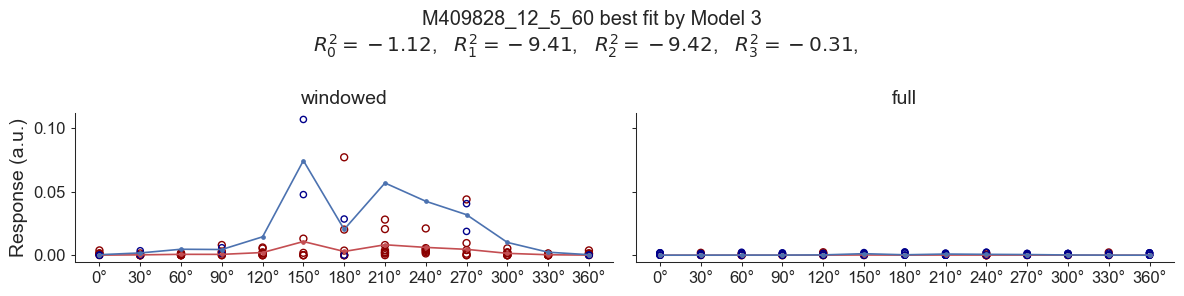

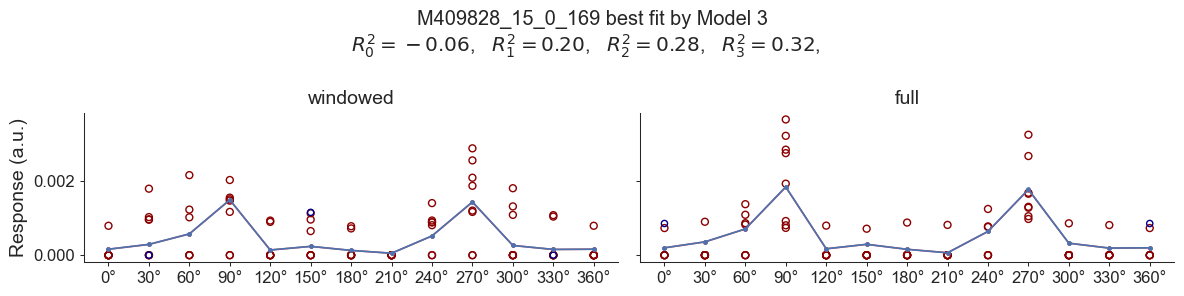

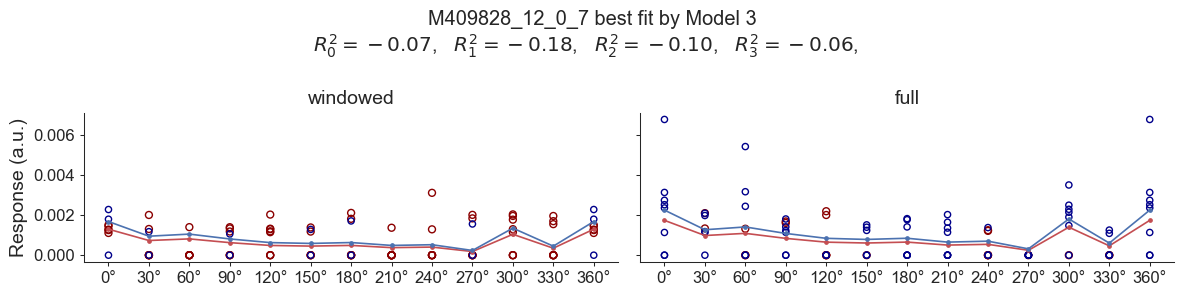

In [864]:
for best_model_i in range(4):
    roi_ids = np.random.choice(best_model.index[(best_model == best_model_i)], size=3, replace=False)
    
    for roi_id in roi_ids:
        fig, axs = debug_plot_responses(roi_id)
        subtitle = ""
        for i in range(4):
            r2 = models_df.at[roi_id, f"r2_valid_model{i}"]
            subtitle += f"$R^2_{i} = {r2:.2f}$,   "

        fig.suptitle(f"{roi_id} best fit by Model {best_model_i}\n{subtitle}")

        # plot model fit
        if best_model_i == 0:
            r = models_df.at[roi_id, "pred_response_model0"]
            for ax in axs:
                ax.axhline(y=r, color="black", linestyle="dashed")
        elif best_model_i == 1:
            tc = eval(models_df.at[roi_id, "tuning_curve_model1"])
            axs[0].plot(directions, np.take(tc[:12], indices=range(len(directions)), mode="wrap"), color="black", marker=".")
            axs[1].plot(directions, np.take(tc[12:], indices=range(len(directions)), mode="wrap"), color="black", marker=".")
        elif best_model_i == 2:
            tc = eval(models_df.at[roi_id, "tuning_curves_model2"])
            axs[0].plot(directions, np.take(tc[:12], indices=range(len(directions)), mode="wrap"), color="black", marker=".")
            axs[1].plot(directions, np.take(tc[12:], indices=range(len(directions)), mode="wrap"), color="black", marker=".")
        elif best_model_i == 3:
            tcw = eval(models_df.at[roi_id, "dgw_tuning_curves_model3"])
            tcf = eval(models_df.at[roi_id, "dgf_tuning_curves_model3"])
            for ax, tc in zip(axs, (tcw, tcf)):
                ax.plot(directions, np.take(tc[:12], indices=range(len(directions)), mode="wrap"), color="r", marker=".")
                ax.plot(directions, np.take(tc[12:], indices=range(len(directions)), mode="wrap"), color="b", marker=".")

# Plot sample tuning curves for high-scoring ROIs

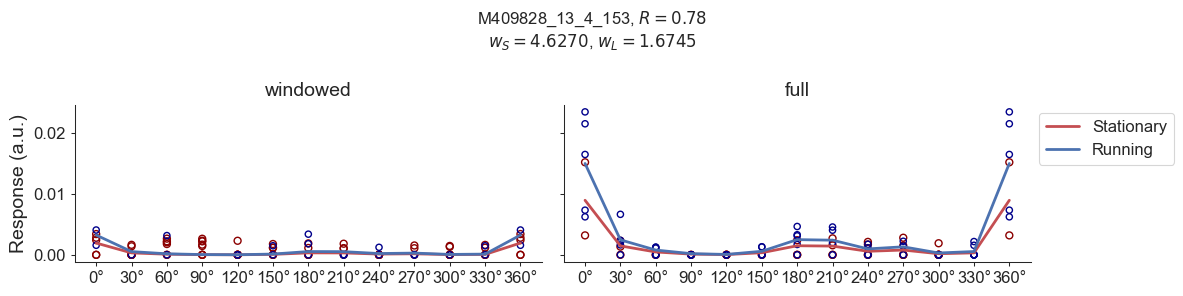

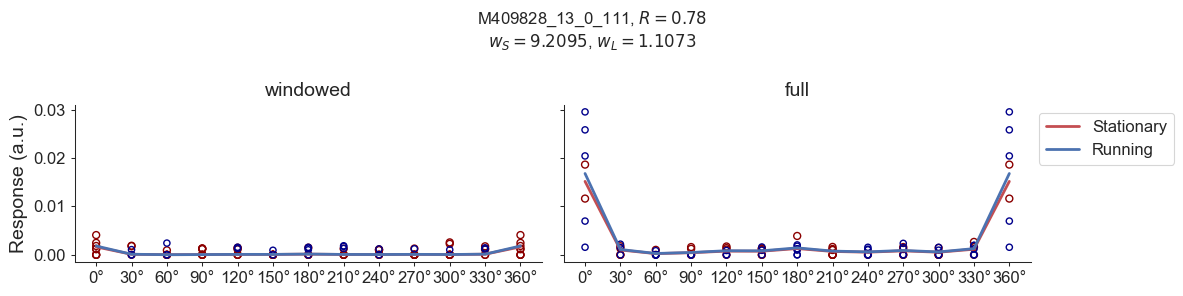

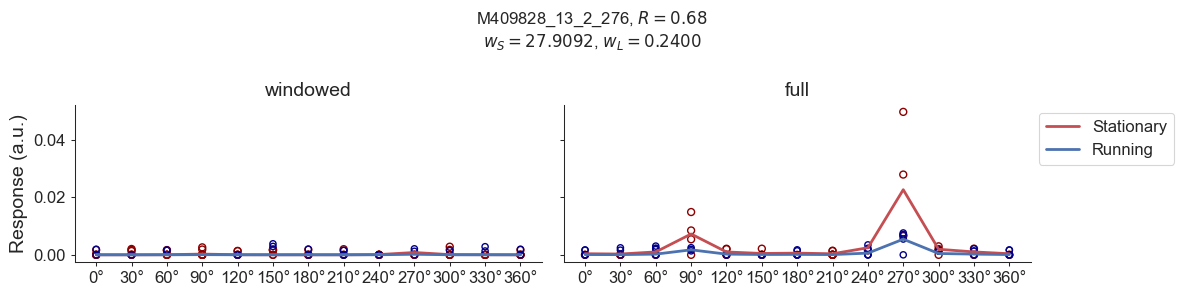

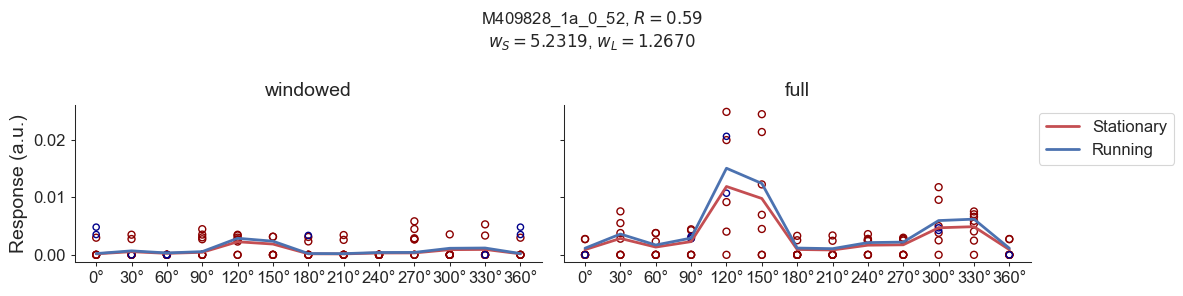

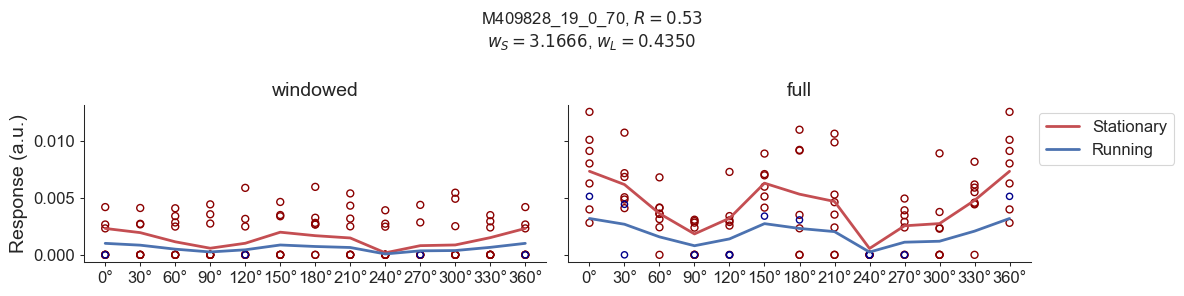

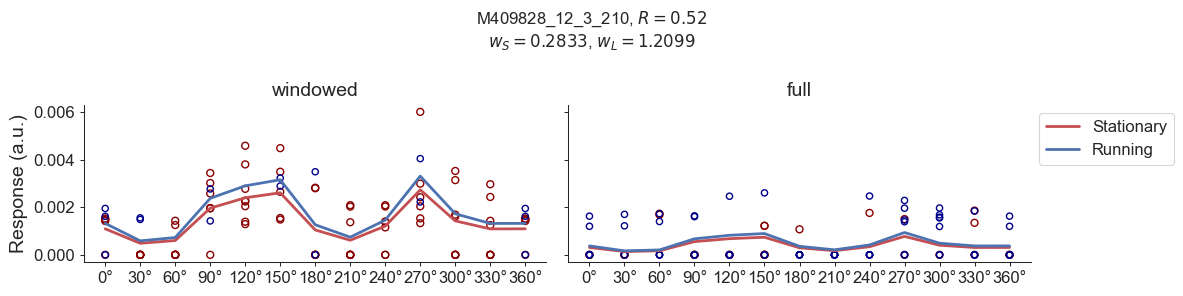

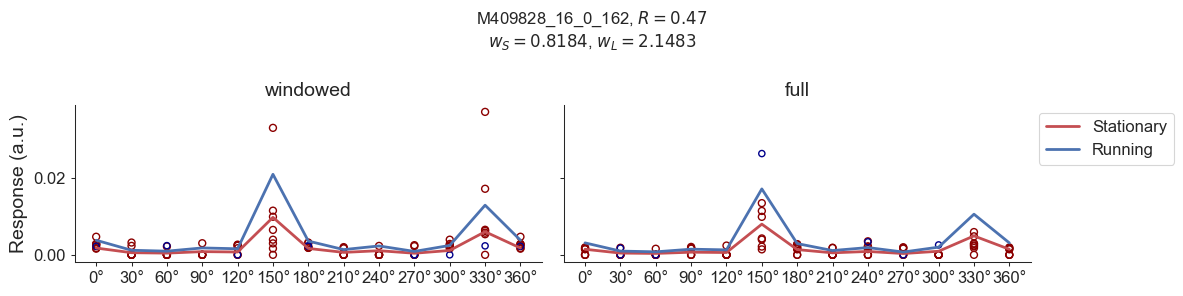

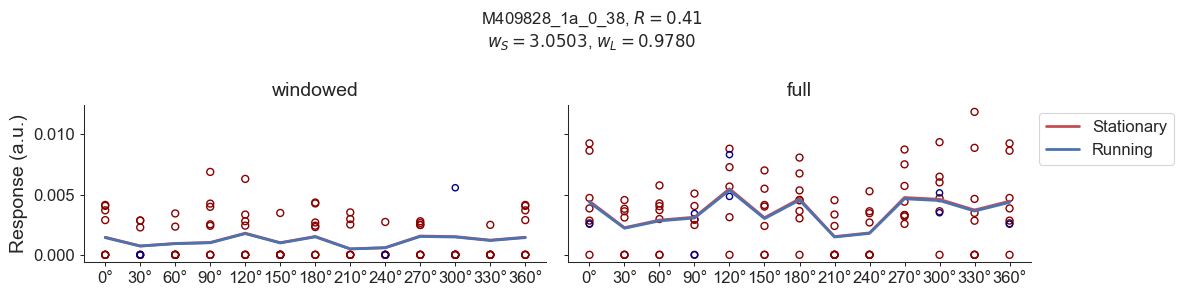

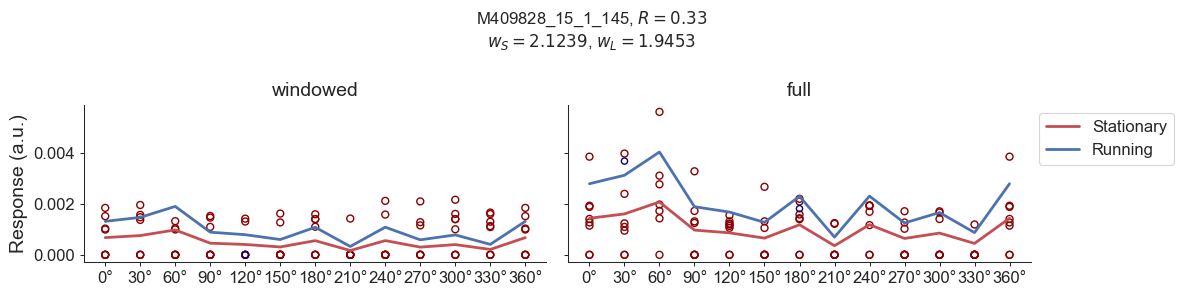

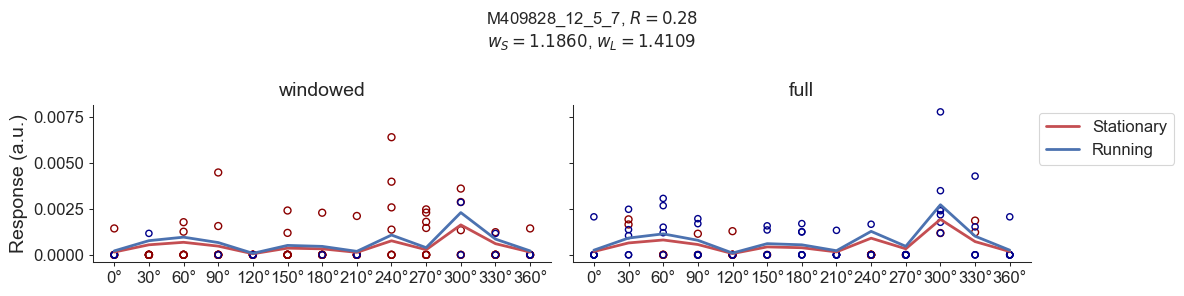

In [466]:
df = model_tune_run_gain_df[model_tune_run_gain_df.r_valid >= 0.25].sort_values("r_valid", ascending=False)
stat_kwargs = dict(color="r")
run_kwargs = dict(color="b")
dgw_kwargs = dict(linestyle="dashed", linewidth=1.5, marker=".")
dgf_kwargs = dict(linestyle="solid", linewidth=2, marker=".")



# Choose random samples
df = df[df.index.isin(np.random.choice(df.index, 10))].sort_values("r_valid", ascending=False)
for row in df.itertuples():
    weights = row.weights
    dgw_tuning_curves = row.dgw_tuning_curves
    dgf_tuning_curves = row.dgf_tuning_curves

    # REMOVE THIS ONCE RE-TRAINED
    model_tune_run_gain.weights_ = weights
    pred = model_tune_run_gain.predict(model_tune_run_gain._all_dg_X)
    dgw_tuning_curves, dgf_tuning_curves = pred[:24], pred[24:]

    filt, roi = plane_group_filter(row.roi_id)
    fig, axs = plt.subplots(figsize=(12, 3), ncols=2, sharey=True, tight_layout=True)

    for group in iter_plane_groups(filter=filt):
        for ax, dg_type, tc in zip(axs, DG_TYPES, (dgw_tuning_curves, dgf_tuning_curves)):
            dg = group[f"drifting_gratings_{dg_type}"]
            pref_sf_index = dg["pref_cond_index"][roi, 1]
            trial_responses = dg["trial_responses"][roi, :, pref_sf_index] # shape (n_dir, n_trials)
            trial_running_speeds = np.abs(dg["trial_running_speeds"][:, pref_sf_index]) # same shape ^
            running_trials = trial_running_speeds > 1
            stationary_trials = trial_running_speeds < 1
            tc_stat, tc_run = tc[:12], tc[12:]
            
            ax.set_title(dg_type)
            ax.plot(directions, tc_stat.take(range(len(directions)), mode="wrap"), label="Stationary", color="r", lw=2)
            ax.plot(directions, tc_run.take(range(len(directions)), mode="wrap"), label="Running", color="b", lw=2)

            for di, d in enumerate(directions):
                di %= 12
                r_stat = trial_responses[di, stationary_trials[di]]
                r_run = trial_responses[di, running_trials[di]]
                ax.scatter([d]*len(r_stat), r_stat, edgecolor="darkred", facecolor="none", lw=1, s=25)
                ax.scatter([d]*len(r_run), r_run, edgecolor="darkblue", facecolor="none", lw=1, s=20)
    
            ax.set_xticks(directions, labels=[f"{d}°" for d in directions])

    axs[0].set_ylabel("Response (a.u.)")
    fig.suptitle(f"{row.roi_id}, $R = {row.r_valid:.2f}$\n$w_S = {row.weights[-2]:.4f}$, $w_L = {row.weights[-1]:.4f}$", fontsize=12)
    axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=axs[-1].transAxes)

<Axes: >

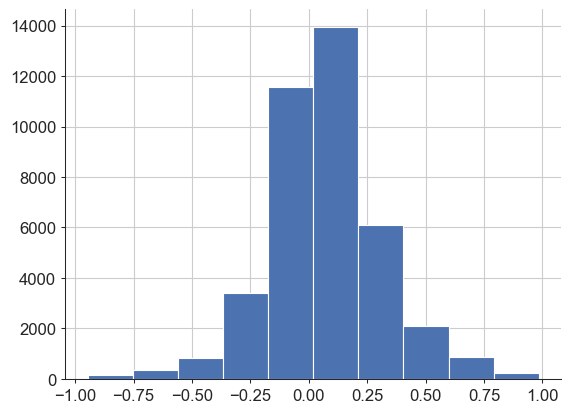

In [472]:
metrics_df.ssi_avg.hist()

# Examine Surround Modulation Index (SMI) across models

<Axes: >

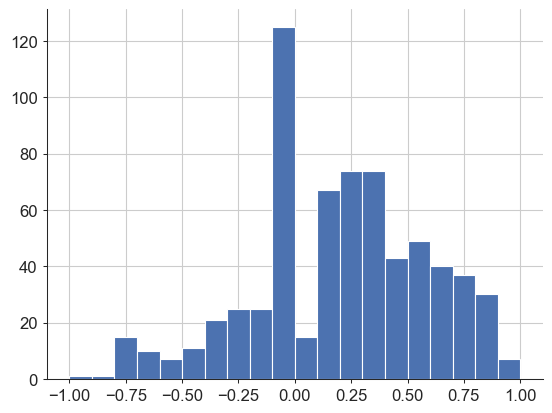

In [153]:
model = MODELS[3]
r_thresh = 0

df_3 = []

for roi_id in sig_fit_df.index[sig_fit_df.best_model == 3]:
    r_valid = models_df.at[roi_id, f"r_valid_model3"]
    state = eval(models_df.at[roi_id, f"state_model3"])
    locomotion_gain = state[-1]
    

    df_3.append(dict(
        roi_id = roi_id,
        r_valid = r_valid,
        locomotion_gain = locomotion_gain,
    ))

df_3 = pd.DataFrame(df_3)
df_3["lmi"] = (df_3.locomotion_gain - 1) / (df_3.locomotion_gain + 1)
df_3[df_3.r_valid >= 0.0]["lmi"].hist(bins=np.arange(-1, 1.1, 0.1))

In [114]:
model_id = 4
model = MODELS[model_id]
r_thresh = 0

df = []

for roi_id in sig_fit_df.index[sig_fit_df.best_model == model_id]:
    r_valid = models_df.at[roi_id, f"r_valid_model{model_id}"]
    state = eval(models_df.at[roi_id, f"state_model{model_id}"])
    size_gain, locomotion_gain = state[-2:]
    

    df.append(dict(
        roi_id = roi_id,
        r_valid = r_valid,
        size_gain = size_gain,
        locomotion_gain = locomotion_gain,
    ))

df = pd.DataFrame(df)
df

roi_id   r_valid  size_gain  locomotion_gain
0       M409828_11_2_0  0.899376   4.867844         3.441995
1       M409828_11_2_1  0.886979   0.039126        12.262586
2     M409828_11_2_260  0.306833   0.417833         1.277701
3       M409828_11_3_1  0.640721   6.751964         3.317149
4      M409828_11_3_20  0.788090   0.017892         1.300454
...                ...       ...        ...              ...
1231   M409828_1f_0_32  0.464530   8.497073         0.112596
1232   M409828_1f_0_69  0.221537   0.734397         2.709140
1233   M409828_1f_0_70  0.289474   6.223006         0.286846
1234   M409828_1f_0_74  0.186893   1.867978         0.657170
1235    M409828_1f_0_8  0.238092   0.358023         3.087797

[1236 rows x 4 columns]

In [119]:
# Compute SMI and LMI
df["smi"] = (df["size_gain"] - 1) / (df["size_gain"] + 1)
df["lmi"] = (df["locomotion_gain"] - 1) / (df["locomotion_gain"] + 1)

Text(0.5, 1.0, 'Model 4 responses')

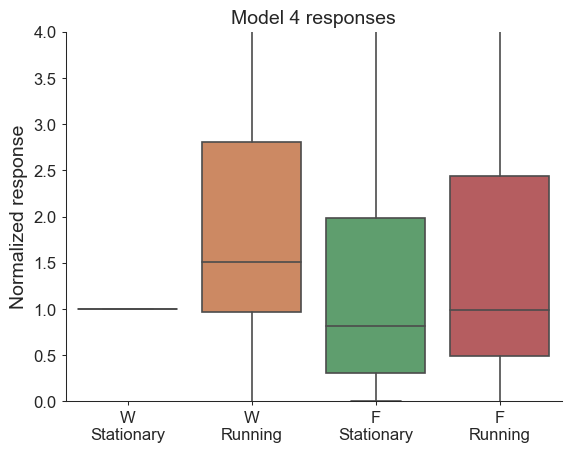

In [118]:
sns.boxplot([[1], df.locomotion_gain, df.size_gain, (df.size_gain*df.locomotion_gain)])
plt.xticks(ticks=np.arange(4), labels=["W\nStationary", "W\nRunning", "F\nStationary", "F\nRunning"])
plt.ylim(0, 4)
plt.ylabel("Normalized response")
plt.title("Model 4 responses")
# plt.gca().axhline(y=1)

(array([ 11.,   9.,  11.,  18.,  24.,  35.,  29.,  41.,  35., 141., 141.,
        118., 126., 102., 108.,  84.,  96.,  68.,  36.,   1.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <BarContainer object of 20 artists>)

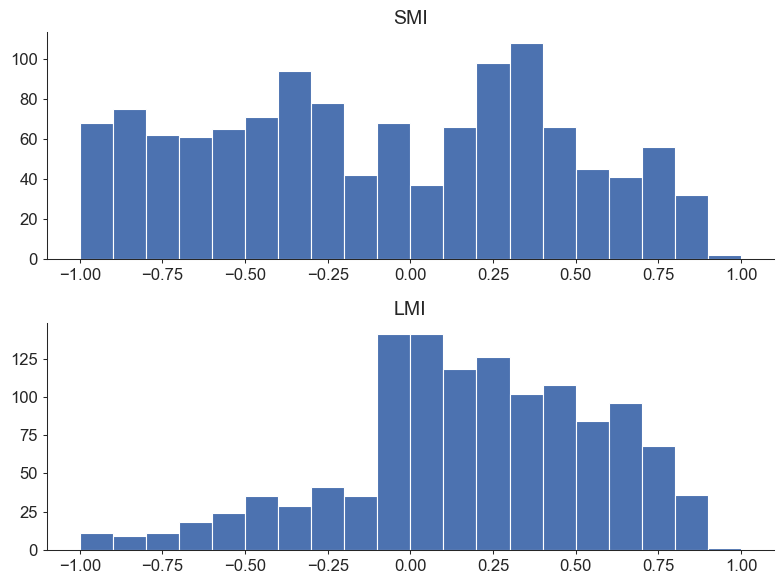

In [123]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
axs[0].set_title("SMI")
axs[0].hist(df.smi, bins=bins)
axs[1].set_title("LMI")
axs[1].hist(df.lmi, bins=bins)

(array([ 0.,  3., 12., 25., 27., 30., 44., 46., 46., 78., 78., 64., 38.,
        29., 18., 12.,  8.,  5.,  3.,  0.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <BarContainer object of 20 artists>)

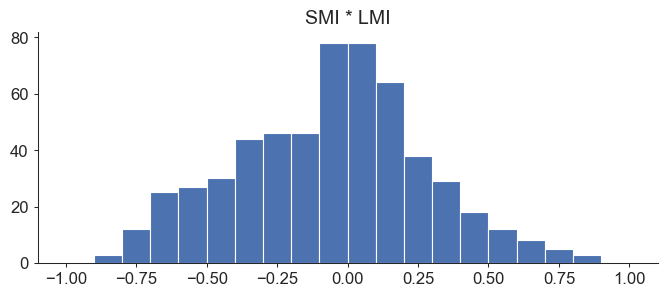

In [146]:
fig, ax = plt.subplots(figsize=(8, 3))
bins = np.arange(-1, 1.1, 0.1)
ax.set_title("SMI * LMI")
ax.hist((df.smi * df.lmi)[df.r_valid >= 0.4], bins=bins)

(array([ 3.,  5.,  5.,  7.,  7.,  9.,  6., 11.,  7., 20., 39., 59., 63.,
        62., 69., 58., 62., 45., 28.,  1.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <BarContainer object of 20 artists>)

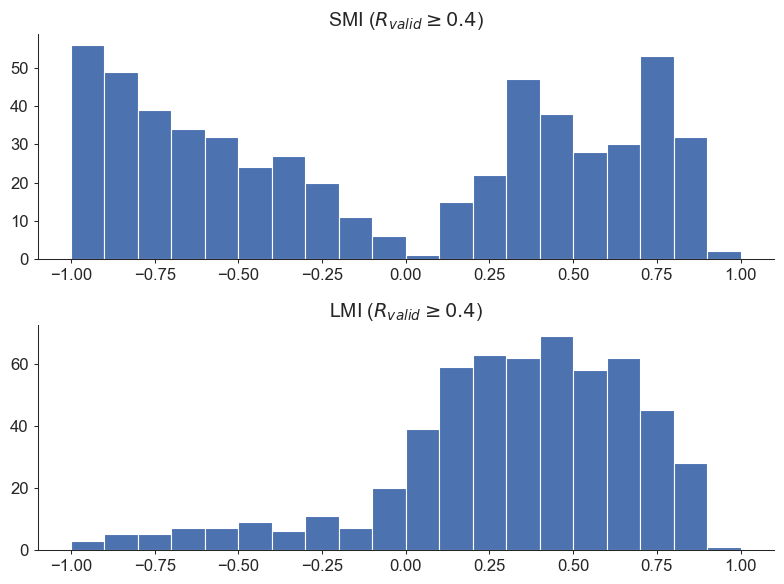

In [125]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
axs[0].set_title("SMI ($R_{valid} \geq 0.4$)")
axs[0].hist(df.smi[df.r_valid >= 0.4], bins=bins)
axs[1].set_title("LMI ($R_{valid} \geq 0.4$)")
axs[1].hist(df.lmi[df.r_valid >= 0.4], bins=bins)

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2)
ax.set_title("SSI (running)")

In [102]:
(sig_fit_df.best_model == model_id) & (models_df[f"r_valid_model{model_id}"] >= 0.4)

roi_id
M409828_11_0_89        1
M409828_11_1_159       3
M409828_11_1_2      None
M409828_11_1_4      None
M409828_11_2_0         4
                    ... 
M409828_1f_0_70        4
M409828_1f_0_74        4
M409828_1f_0_8         4
M409828_1f_0_9      None
M409828_1f_0_90        1
Name: best_model, Length: 7464, dtype: object

In [449]:
size_gain = model_tune_run_gain_df.weights.apply(itemgetter(-2)).values
locomotion_gain = model_tune_run_gain_df.weights.apply(itemgetter(-1)).values

np.median(size_gain), np.median(locomotion_gain)

(0.9268229923758862, 1.119777114350505)

([<matplotlib.axis.XTick at 0x7fa632f7c8e0>,
 [Text(0, 0, 'Windowed'), Text(1, 0, 'Full-Field')])

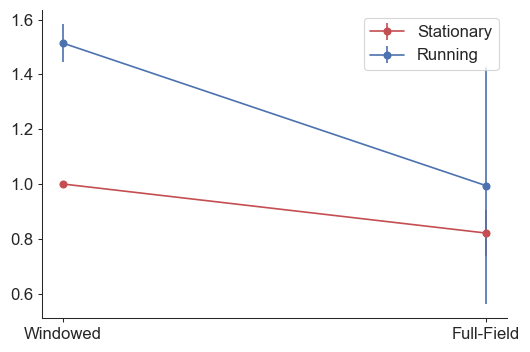

In [141]:
incl = df.r_valid >= 0#.4
ws = 1
wr = df.locomotion_gain[incl]
fs = df.size_gain[incl]
fr = (df.size_gain*df.locomotion_gain)[incl]
# f = np.mean
f = np.median

plt.figure(figsize=(6, 4))
plt.errorbar(x=[0, 1], y=[1, f(fs)], yerr=[0, fs.std()/np.sqrt(len(fs))], color="r", marker="o", label="Stationary")
plt.errorbar(x=[0, 1], y=[f(wr), f(fr)], yerr=[wr.std()/np.sqrt(len(fs)), fr.std()/np.sqrt(len(fr))], color="b", marker="o", label="Running")
plt.legend(loc="upper right")
plt.xticks(ticks=[0, 1], labels=["Windowed", "Full-Field"])

In [142]:
f(fr) / f(wr)

0.6566415964530413

In [143]:
f(fs) / 1

0.821059123843686

Text(0.5, 0.98, 'Inclusion: $R_{valid} \\geq 0.5$')

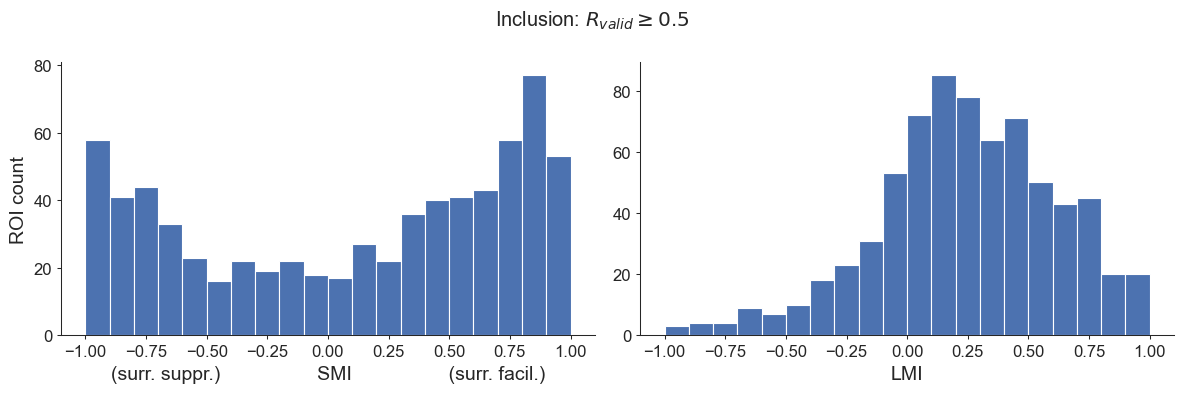

In [462]:
# Compute SMI (surround modulation index) from size gain term
# Compute LMI (locomotion modulation index) from locomotion gain term
r_thresh = 0.5
incl = model_tune_run_gain_df.r_valid >= r_thresh
smi = (size_gain - 1) / (size_gain + 1)
lmi = (locomotion_gain - 1) / (locomotion_gain + 1)

fig, axs = plt.subplots(figsize=(12, 4), ncols=2, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)

axs[0].set_xlabel("(surr. suppr.)                  SMI                  (surr. facil.)")
axs[0].hist(smi[incl], bins=bins)
axs[0].set_ylabel("ROI count")

axs[1].set_xlabel("LMI")
axs[1].hist(lmi[incl], bins=bins)

fig.suptitle(f"Inclusion: $R_{{valid}} \geq {r_thresh}$")

# Miscellaneous

See how different SF responses line up

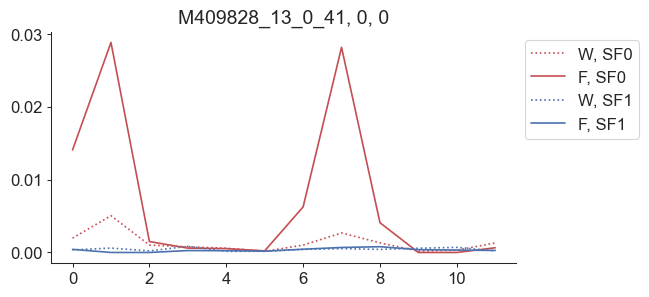

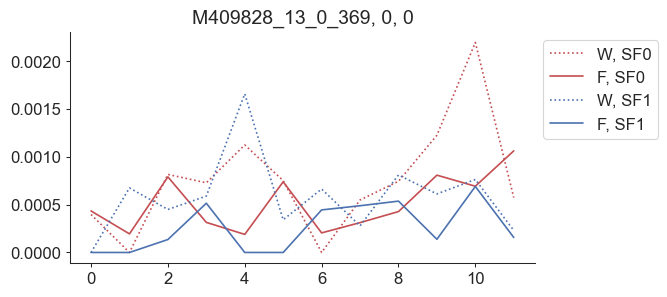

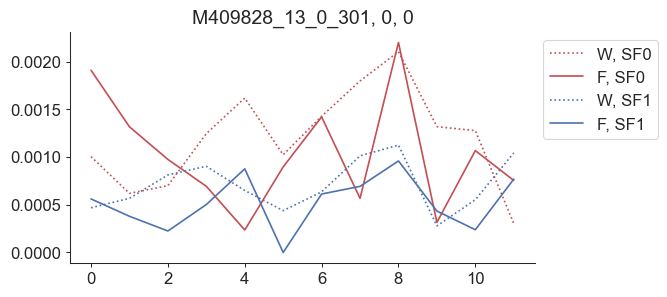

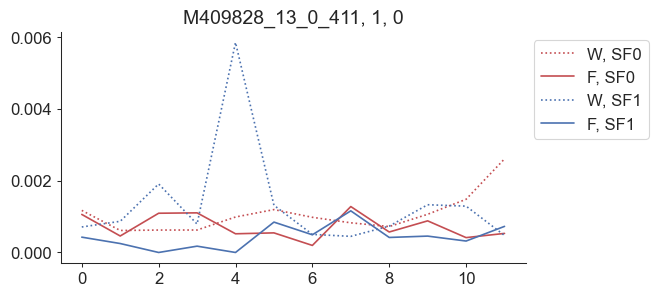

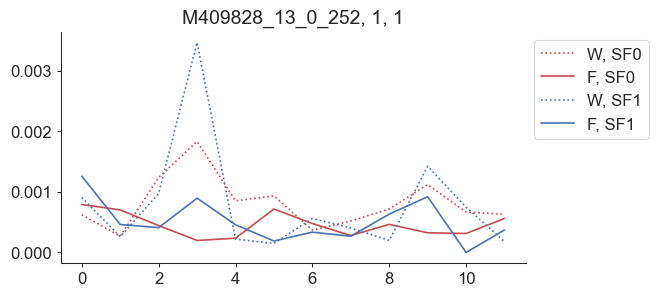

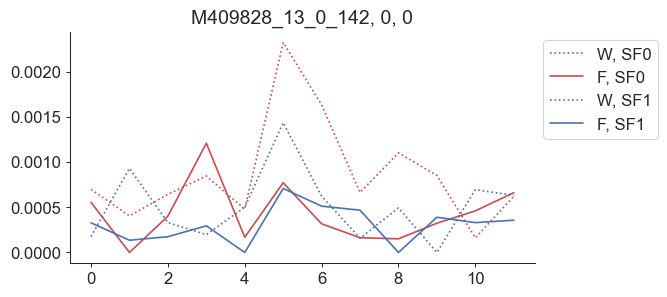

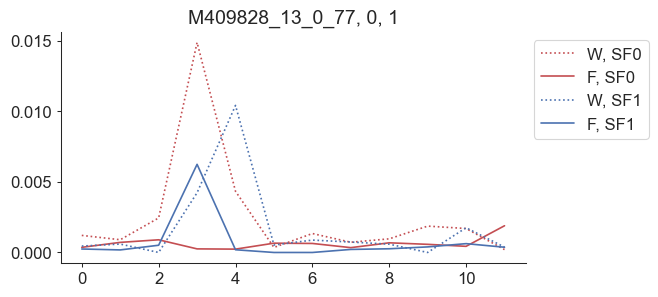

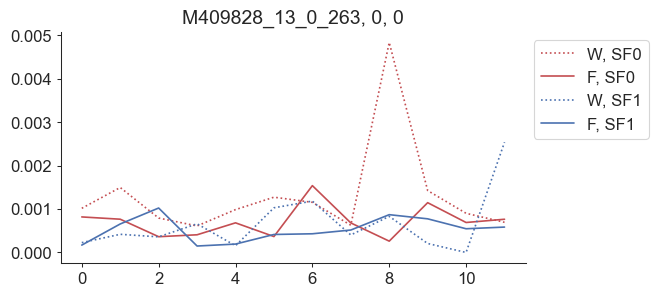

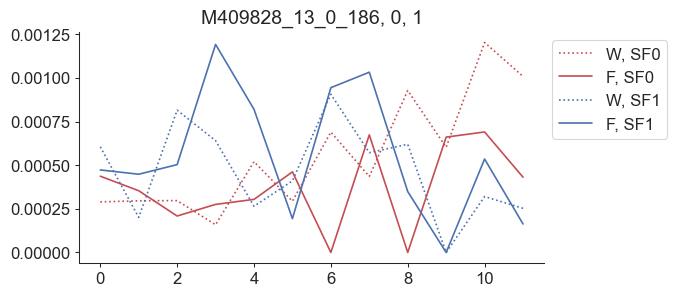

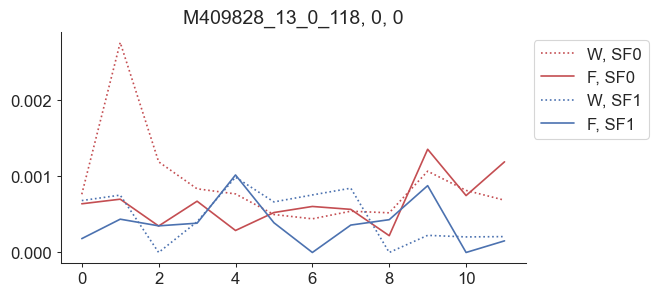

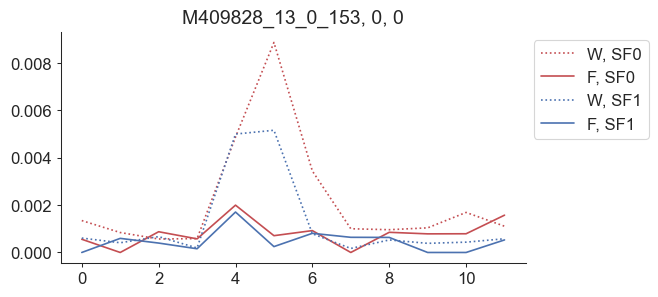

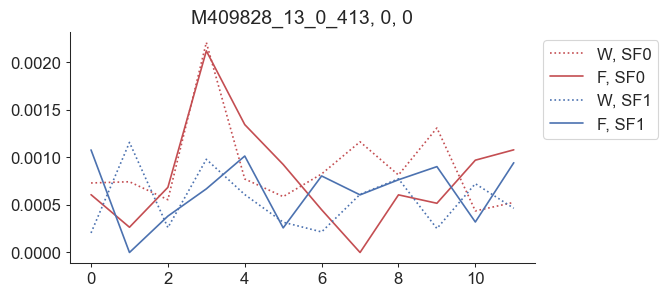

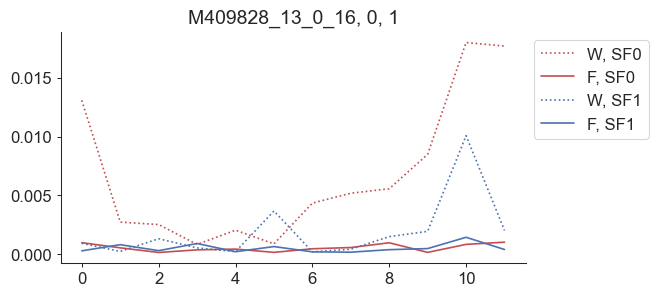

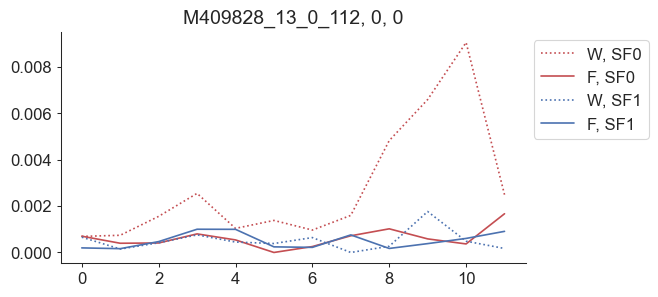

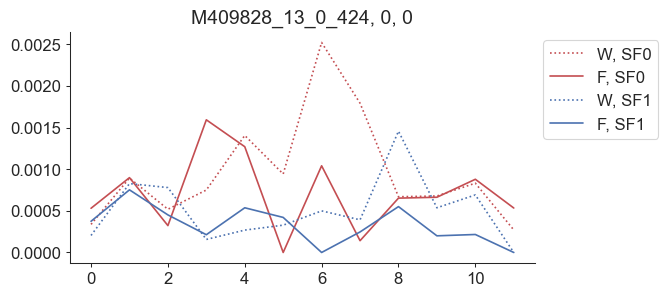

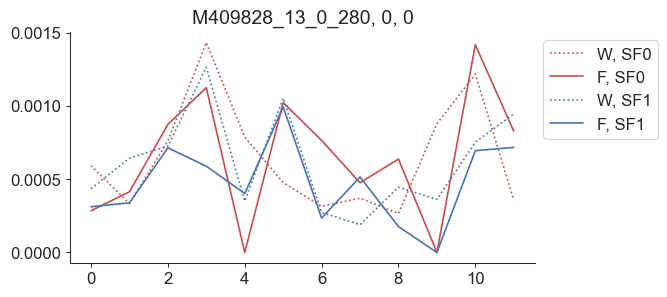

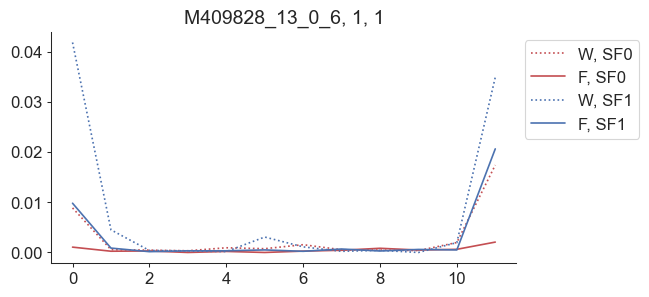

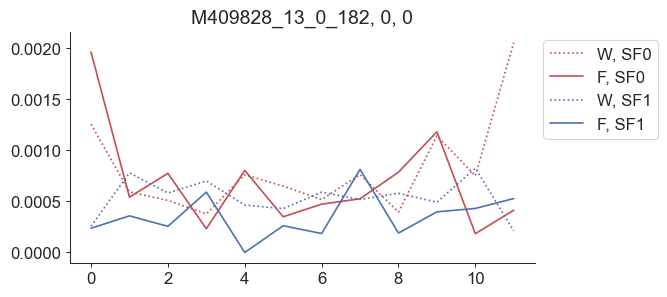

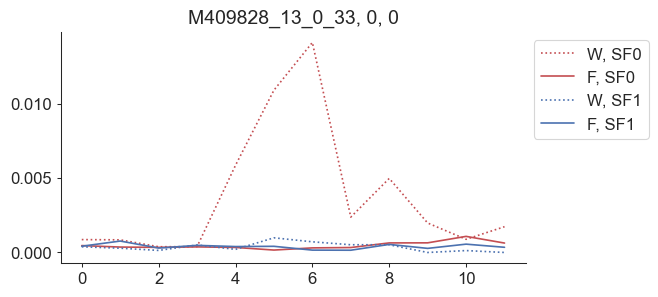

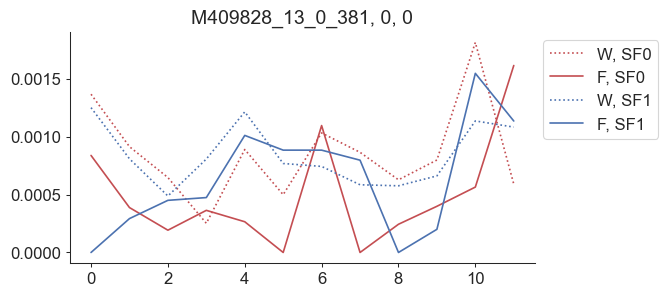

In [393]:
for group in iter_plane_groups(filter=dict(mouse=409828, column=1, volume=3, plane=0)):
    dgw = group["drifting_gratings_windowed"]
    dgf = group["drifting_gratings_full"]
    dgw_trial_resp = np.nanmean(dgw["trial_responses"][()], axis=-1)
    dgf_trial_resp = np.nanmean(dgf["trial_responses"][()], axis=-1)

    for roi in np.random.choice(np.where(dgw["frac_responsive_trials"][()] >= 0.5)[0], size=20):
        fig, ax = plt.subplots(figsize=(6, 3))
        for sf_i in range(2):
            ax.plot(dgw_trial_resp[roi, :, sf_i], color=("r" if sf_i == 0 else "b"), ls="dotted", label=f"W, SF{sf_i}")
            ax.plot(dgf_trial_resp[roi, :, sf_i], color=("r" if sf_i == 0 else "b"), label=f"F, SF{sf_i}")
        ax.set_title(f"{get_roi_id(group, roi)}, {dgw['pref_cond_index'][roi, 1]}, {dgf['pref_cond_index'][roi, 1]}")
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)